<a href="https://colab.research.google.com/github/JulesCollenne/MelanomaAsymmetry/blob/main/CleanMela.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io
from scipy.stats import kurtosis, skew
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import roc_auc_score
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import keras
import os
from shapely.geometry import LineString
from shapely.geometry import Point
import sklearn
import sklearn.preprocessing
import matplotlib.pyplot as plt
import cv2
import numpy as np
import skimage
from sklearn.metrics import roc_curve
import scipy.fft
from numpy.fft import fftshift
from google.colab.patches import cv2_imshow
from sklearn.decomposition import PCA
import math
import tensorflow as tf
from keras.models import Sequential
from keras.optimizers import SGD
from numpy import all, any, array, arctan2, cos, sin, exp, dot, log, logical_and, roll, sqrt, stack, trace, unravel_index, pi, deg2rad, rad2deg, where, zeros, floor, full, nan, isnan, round, float32
from numpy.linalg import det, lstsq, norm
from cv2 import resize, GaussianBlur, subtract, KeyPoint, INTER_LINEAR, INTER_NEAREST
from functools import cmp_to_key
import logging
from os.path import isfile, join
from os import listdir
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import auc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy
from keras.layers import Lambda
from random import randrange
import keras
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras.optimizers import SGD

In [ ]:
!unzip /content/drive/MyDrive/ISIC_2019.zip

# Constants

In [ ]:
quad_rgb = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (0,0,0)]
base = 'ISIC_2019/'
img_shape = (300,300)

# Metrics

In [ ]:
def visu_results(y_test, predictions, normalize=None, confidence=None):
  y_test = np.asarray(y_test)
  if len(y_test.shape) == 1:
    y_testOH = keras.utils.to_categorical(y_test)
  else:
    y_testOH = y_test.copy()
    y_test = np.argmax(y_test, axis=1)
  if len(predictions.shape) == 1:
    predictions = keras.utils.to_categorical(predictions)
    
  cm = confusion_matrix(np.argmax(y_testOH, axis=1), np.argmax(predictions, axis=1), normalize=normalize)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                    display_labels=('Melanome', 'Naevus'))
  disp.plot()
  print(classification_report(np.argmax(y_testOH, axis=1),
                            np.argmax(predictions, axis=1),
                            target_names=('Mélanome', 'Naevus')))
  if confidence is None:
    print('ROC score on test set : ',roc_auc_score(y_testOH, predictions))
    fpr, tpr, thresh = roc_curve(np.asarray(y_testOH)[:,0], np.asarray(predictions)[:,0])
  else:
    print('ROC score on test set : ',roc_auc_score(y_test, confidence))
    fpr, tpr, thresh = roc_curve(np.asarray(y_test), np.asarray(confidence))
  auc_keras = auc(fpr, tpr)
  plt.show()
  plt.figure(1)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr, tpr, label='Area = {:.3f}'.format(auc_keras))
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')
  plt.legend(loc='lower right')
  plt.xlim([0,1])
  plt.ylim([0,1])
  plt.show()

In [ ]:
def run_and_test(featuresNames, parameters, clf, scoring = 'roc_auc', hasConfidence=False, centering=False):
  print('Loading features...')
  loader = DataLoader(featuresNames)
  X_train, y_train, X_test, y_test = loader.load(centering=centering)
  print('GridSeach...')
  gs = GridSearchCV(clf, parameters, scoring=scoring, n_jobs=-1, verbose=10).fit(X_train, y_train)

  print(gs.best_score_)
  print(gs.best_estimator_)
  clf = gs.best_estimator_

  print('Best estimator...')
  clf.fit(X_train, y_train)

  predictions = clf.predict(X_test)
  if hasConfidence:
    confidence = clf.decision_function(X_test)
    visu_results(y_test, predictions, confidence=confidence)
  else:
    visu_results(y_test, predictions)

  print('Cross_val_score (auc):',np.mean(cross_val_score(clf, X_train, y_train, scoring=scoring)))

# Mathematics and axes

In [ ]:
# In : Grayscale image
# Out : Number of black pixels
def get_area(img):
  return len([pixel for row in img for pixel in row if pixel == 0])

# In : Grayscale image
# Out : Numpy array of points representing white pixels of the image
def get_points(img):
  return np.asarray([(j,i) for i, row in enumerate(img) for j, pixel in enumerate(row) if pixel != 0])

# In : Array of points
# Out : Coordinates of the mean coordinates
def get_center(points):
  length = points.shape[0]
  sum_x = np.sum(points[:,0])
  sum_y = np.sum(points[:,1])
  return sum_x/length, sum_y/length

# In : Grayscale image (mask of the lesion)
# Out : Angle of rotation minimizing the area difference between the two halves of image
def get_axis_area(mask, center):
  aires = {}
  cX, cY = center
  for angle in range(0,180, 10):
    res = rotate_img(mask, -angle, (cX, cY))
    taille = int(res.shape[0]/2)
    aires[angle] = (res[:taille][:] != res[taille:][:]).sum()

  areas = np.argmin([aires[i] for i in aires.keys()])
  best_angle = areas * 10
  return best_angle
 
# In : Point p, line d
# Out : True if determinant is negative, False otherwise
def relative_side_of_point(p, d):
  return (d[0][0]-p[0])*(d[1][1]-p[1])-(d[0][1]-p[1])*(d[1][0]-p[0]) < 0

# In : List of points, method used to compute the symmetry axes
# Out : Symmetry axes
# method possible values : PCA, Minim
# PCA : Compute axes using PCA
# Minim : Compute axes using area difference minimization
def get_axes(points, method='PCA', mask=None):
  center = get_center(points)
  cX, cY = center
  if method == 'PCA':
    pca = PCA(n_components=2).fit(points)
    axes = []
    for i, (comp, var) in enumerate(zip(pca.components_, pca.explained_variance_ratio_)):
      comp = comp * var * 400
      axes.append([[cX, cY], [cX+comp[0], cY+comp[1]]])
    return np.asarray(axes)
  elif method == 'Minim':
    best_angle = get_axis_area(mask, center)

    enX = int(400*cos(-best_angle))
    enY = int(400*sin(-best_angle))

    axe1 = ((cX-enX, cY-enY),(cX+enX, cY+enY))
    axe2 = ((cX+enY, cY-enX),(cX-enY, cY+enX))
    return np.asarray(axe1), np.asarray(axe2)
  return None

# In : Mask of the lesion, Points, axe1, axe2
# Out : Quadrants of the image (mask.shape)
# Quadrants has 4 possible values : 
# -1 : Not in the lesion, 0,1,2,3 : Quad number of the (i,j) pixel
def make_quadrants(mask, points, axe1, axe2):
  quadrants = np.ones((mask.shape[0], mask.shape[1]), dtype=np.uint8) * -1
  for p in points:
    i = p[1]
    j = p[0]
    if relative_side_of_point(p, axe1):
      if relative_side_of_point(p, axe2):
        quadrants[i][j] = 0
      else:
        quadrants[i][j] = 1
    else:
      if relative_side_of_point(p, axe2):
        quadrants[i][j] = 2
      else:
        quadrants[i][j] = 3
  return quadrants

# In : Image, quadrants, alpha
# Out : Resulting image of the fusion between alpha*img + (1-alpha)*quadrants
# alpha is the percentage of the original image
def quad_on_img(img, quadrants, alpha):
  img_points = np.zeros(img.shape, dtype=np.uint8)
  for i, row in enumerate(img):
    for j, pixel in enumerate(row):
      img_points[i][j] = np.asarray(quad_rgb[quadrants[i][j]])

  res = np.zeros((img.shape), dtype=np.uint8)
  for i, row in enumerate(img_points):
    for j, pixel in enumerate(row):
      if pixel.any() == -1:
        res[i][j] = img[i][j]
      else:
        res[i][j] = img[i][j] * alpha + img_points[i][j] * (1-alpha)
  return res

# In : 2 points (x,y)
# Out : Euclidian distance between the two points
def distance(p1, p2):
  return np.sqrt(pow(p1[0]-p2[0],2) + pow(p1[1]-p2[1], 2))

# In : Image, angle in degree, scale
# Out : Rotated image
def rotate_img(image, angle, center, scale=1.):
  (h, w) = image.shape[:2]
  M = cv2.getRotationMatrix2D(center, angle, scale)
  rotated = cv2.warpAffine(image, M, (w, h))
  return rotated

# Features's functions

## Utils

In [ ]:
# In : Any feature by quadrant (list of list with shape (4,x))
# Out : Mean differences for each quadrant relative to the axes, and center
# Output shape : (3*x)
def feature_diff(feature):
  result = []
  feature = np.asarray(feature)

  somme = (np.abs(feature[0] - feature[3]) + np.abs(feature[1] - feature[2])) / 2
  result += list(somme)

  somme = (np.abs(feature[0] - feature[1]) + np.abs(feature[2] - feature[3]) + np.abs(feature[0] - feature[2]) + np.abs(feature[1] - feature[3])) / 4
  result += list(somme)

  # Moyenne des différences par rapport aux axes
  H = np.abs((feature[0] + feature[1]) / 2 - (feature[2] + feature[3]) / 2)
  V = np.abs((feature[0] + feature[2]) / 2 - (feature[2] + feature[1]) / 2)
  result += list((H + V) / 2)
  return result

# In : Any feature by quadrant except the feature is a scalar
# Out : Mean differences for each quadrant relative to the axes, and center
def scalar_feature_diff(feature):
  result = []
  feature = np.asarray(feature)

  somme = (np.abs(feature[0] - feature[3]) + np.abs(feature[1] - feature[2])) / 2
  result.append(somme)

  somme = (np.abs(feature[0] - feature[1]) + np.abs(feature[2] - feature[3]) + np.abs(feature[0] - feature[2]) + np.abs(feature[1] - feature[3])) / 4
  result.append(somme)

  # Moyenne des différences par rapport aux axes
  H = np.abs((feature[0] + feature[1]) / 2 - (feature[2] + feature[3]) / 2)
  V = np.abs((feature[0] + feature[2]) / 2 - (feature[2] + feature[1]) / 2)
  result.append((H + V) / 2)
  return result

## Basics

In [ ]:
# Basic features
# Mean, std, kurtosis, skewness and shannon entropy
def f_beta(img, mask):
  feature = []
  feature.append(np.mean(img, axis=(0,1)))
  feature.append(np.std(img, axis=(0,1)))
  feature.append(kurtosis(kurtosis(img, axis=0), axis=0))
  feature.append(skew(skew(img, axis=0), axis=0))
  feature.append(skimage.measure.shannon_entropy(img))
  return np.asarray(feature).flatten()

#Basic feature by quadrant
# Mean, std, kurtosis, skewness and shannon entropy
def f_beta_quad(img, quadrants):
  features = []
  for quad_num in range(4):
    tmp_img = [img[i][j] for i in range(img.shape[0]) for j in range(img.shape[1])
              if quadrants[i][j] == quad_num]
    feature = []
    feature.append(np.mean(tmp_img, axis=0))
    feature.append(np.std(tmp_img, axis=0))
    feature.append(kurtosis(tmp_img, axis=0))
    feature.append(skew(tmp_img, axis=0))
    feature = list(np.asarray(feature).flatten())
    feature += skimage.measure.shannon_entropy(tmp_img)
    features.append(np.asarray(feature).flatten())
  return feature_diff(np.asarray(features))

###Save

In [ ]:
def get_features(img, mask):
  points = np.asarray(get_points(mask))
  center = get_center(points)
  axe1, axe2 = get_axes(points, method='PCA', mask=mask)
  quadrants = make_quadrants(mask, points, axe1, axe2)
  features = f_beta_quad(img, quadrants)
  return features

path = '/content/drive/MyDrive/Stage_LIS/Features/'
name = 'beta_quad_RGB'

X, y = load_all_data('TRAIN/', verbose=True, get_features=get_features)
np.savetxt(path+'X_train_'+name+'.txt', X)

X, y = load_all_data('TEST/', verbose=True, get_features=get_features)
np.savetxt(path+'X_test_'+name+'.txt', X)

1.0
2.0


KeyboardInterrupt: ignored

In [ ]:
def get_features(img, mask):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
  points = np.asarray(get_points(mask))
  center = get_center(points)
  axe1, axe2 = get_axes(points, method='PCA', mask=mask)
  quadrants = make_quadrants(mask, points, axe1, axe2)
  features = f_beta_quad(img, quadrants)
  return features

path = '/content/drive/MyDrive/Stage_LIS/Features/'
name = 'beta_quad_HSV'

X, y = load_all_data('TRAIN/', verbose=True, get_features=get_features)
np.savetxt(path+'X_train_'+name+'.txt', X)

X, y = load_all_data('TEST/', verbose=True, get_features=get_features)
np.savetxt(path+'X_test_'+name+'.txt', X)

In [ ]:
def get_features(img, mask):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
  points = np.asarray(get_points(mask))
  center = get_center(points)
  axe1, axe2 = get_axes(points, method='PCA', mask=mask)
  quadrants = make_quadrants(mask, points, axe1, axe2)
  features = f_beta_quad(img, quadrants)
  return features

path = '/content/drive/MyDrive/Stage_LIS/Features/'
name = 'beta_quad_Lab'

X, y = load_all_data('TRAIN/', verbose=True, get_features=get_features)
np.savetxt(path+'X_train_'+name+'.txt', X)

X, y = load_all_data('TEST/', verbose=True, get_features=get_features)
np.savetxt(path+'X_test_'+name+'.txt', X)

In [ ]:
def get_features(img, mask):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
  points = np.asarray(get_points(mask))
  center = get_center(points)
  axe1, axe2 = get_axes(points, method='PCA', mask=mask)
  quadrants = make_quadrants(mask, points, axe1, axe2)
  features = f_beta_quad(img, quadrants)
  return features

path = '/content/drive/MyDrive/Stage_LIS/Features/'
name = 'beta_quad_YCrCb'

X, y = load_all_data('TRAIN/', verbose=True, get_features=get_features)
np.savetxt(path+'X_train_'+name+'.txt', X)

X, y = load_all_data('TEST/', verbose=True, get_features=get_features)
np.savetxt(path+'X_test_'+name+'.txt', X)

## Image difference

In [ ]:
# In : Image, axis
# Out : Image difference according to the specified axis
# Axis=0 : Horizontal
# Axis=1 : Vertical
# Axis=2 : Both (diagonal)
def get_diff(image, axis=2):
  if axis not in (0, 1, 2):
    print("Axis parameter is either 0, 1 or 2.")
    print("Please use a correct value")
    exit(1)
  diff = np.zeros((image.shape[0], image.shape[1], image.shape[2]))
  if axis == 2:
    for i in range(len(image)):
      for j in range(len(image[i])):
        for c in range(len(image[i][j])):
          diff[i][j][c] = np.abs(image[i][j][c] - image[image.shape[0]-i-1][image.shape[1]-j-1][c])
  elif axis == 0:
    for i in range(int(len(image)/2)):
      for j in range(len(image[i])):
        for c in range(len(image[i][j])):
          diff[i][j][c] = np.abs(image[i][j][c] - image[image.shape[0]-i-1][j][c])
  elif axis == 1:
    for i in range(len(image)):
      for j in range(int(len(image[i])/2)):
        for c in range(len(image[i][j])):
          diff[i][j][c] = np.abs(image[i][j][c] - image[i][image.shape[1]-j-1][c])
  return diff

## Mean color

In [ ]:
# In : Quadrants, image
# Out : Mean color for each quadrant
def get_mean_colors(quadrants, img):
  moyennes = []
  for quad_num in range(4):
    moyennes.append(np.mean([img[i][j] for i in range(img.shape[0]) for j in range(img.shape[1])
    if quadrants[i][j] == quad_num], axis=0))
  return moyennes

# Feature function
# In : Image, quadrants
# Out : Feature color mean
def f_color_mean(img, quadrants):
  moyennes = get_mean_colors(quadrants, img)
  return feature_diff(moyennes)

### Debug

In [ ]:
def draw_mean_colors(full_quads, img, moyennes):
  result = np.zeros(img.shape)
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      if full_quads[i][j] != -1:
        result[i][j] = img[i][j] * 0 + moyennes[int(full_quads[i][j])] * 1
      else:
        result[i][j] = img[i][j]
  return result

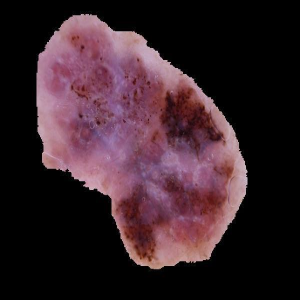

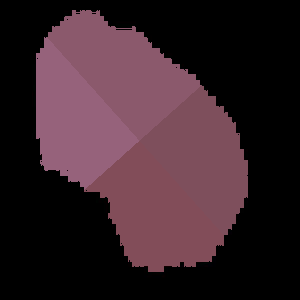

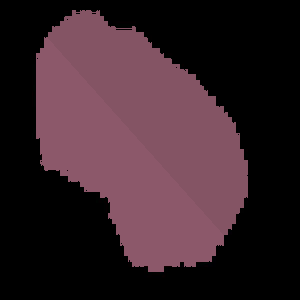

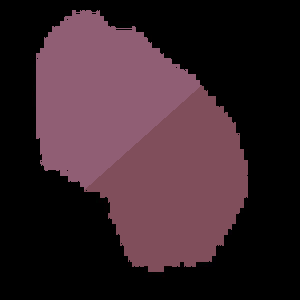

In [ ]:
IMG_SIZE = (300,300)
path = '/content/ISIC_2019/SEGMENTEES/HIGH_RESOL_FILLED/TEST/MEL/ISIC_0033710.JPG'
mask_path = '/content/ISIC_2019/SEGMENTEES/MASK/TEST/MEL/ISIC_0033710_Mask.jpg'
img = cv2.resize(cv2.imread(path), IMG_SIZE)
mask = cv2.resize(cv2.imread(mask_path, 0), IMG_SIZE)
points = np.asarray(get_points(mask))
axe1, axe2 = get_axes(points, method='Minim', mask=mask)
quadrants = make_quadrants(mask, points, axe1, axe2)
moyennes = get_mean_colors(quadrants, img)
cv2_imshow(img)
res = draw_mean_colors(quadrants, img, moyennes)
cv2_imshow(res)
moyennesV = [(moyennes[0] + moyennes[1])/2, (moyennes[2] + moyennes[3])/2]
moyennesV = [moyennesV[0], moyennesV[0], moyennesV[1], moyennesV[1]]
res = draw_mean_colors(quadrants, img, moyennesV)
cv2_imshow(res)
moyennesH = [(moyennes[0] + moyennes[2])/2, (moyennes[1] + moyennes[3])/2]
moyennesH = [moyennesH[0], moyennesH[1], moyennesH[0], moyennesH[1]]
res = draw_mean_colors(quadrants, img, moyennesH)
cv2_imshow(res)

### Save

In [ ]:
def get_features(img, mask):
  points = np.asarray(get_points(mask))
  center = get_center(points)
  axe1, axe2 = get_axes(points, method='Minim', mask=mask)
  quadrants = make_quadrants(mask, points, axe1, axe2)
  features = f_color_mean(img, quadrants)
  return features

path = '/content/drive/MyDrive/Stage_LIS/Features/'
name = 'M_ColorMean'

X, y = load_all_data('TRAIN/', verbose=True, get_features=get_features)
np.savetxt(path+'X_train_'+name+'.txt', X)

X, y = load_all_data('TEST/', verbose=True, get_features=get_features)
np.savetxt(path+'X_test_'+name+'.txt', X)

In [ ]:
def get_features(img, mask):
  features = []
  points = np.asarray(get_points(mask))
  center = get_center(points)
  axe1, axe2 = get_axes(points, method='PCA')
  quadrants = make_quadrants(mask, points, axe1, axe2)
  features = f_color_mean(img, quadrants)
  return features

path = '/content/drive/MyDrive/Stage_LIS/Features/'
name = 'PCA_ColorMean'

X, y = load_all_data('TRAIN/', verbose=True, get_features=get_features)
np.savetxt(path+'X_train_'+name+'.txt', X)

X, y = load_all_data('TEST/', verbose=True, get_features=get_features)
np.savetxt(path+'X_test_'+name+'.txt', X)

In [ ]:
def get_features(img, mask):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
  points = np.asarray(get_points(mask))
  center = get_center(points)
  axe1, axe2 = get_axes(points)
  quadrants = make_quadrants(mask, points, axe1, axe2)
  features = f_color_mean(img, quadrants)
  return features

path = '/content/drive/MyDrive/Stage_LIS/Features/'

X, y = load_all_data('TRAIN/', verbose=True, get_features=get_features)
np.savetxt(path+'X_train_PCA_color_mean_Lab.txt', X)

X, y = load_all_data('TEST/', verbose=True, get_features=get_features)
np.savetxt(path+'X_test_PCA_color_mean_Lab.txt', X)

In [ ]:
def get_features(img, mask):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
  points = np.asarray(get_points(mask))
  center = get_center(points)
  axe1, axe2 = get_axes(points)
  quadrants = make_quadrants(mask, points, axe1, axe2)
  features = f_color_mean(img, quadrants)
  return features

path = '/content/drive/MyDrive/Stage_LIS/Features/'
name = 'PCA_color_mean_HSV'

X, y = load_all_data('TRAIN/', verbose=True, get_features=get_features)
np.savetxt(path+'X_train_'+name+'.txt', X)

X, y = load_all_data('TEST/', verbose=True, get_features=get_features)
np.savetxt(path+'X_test_'+name+'.txt', X)

### Results

Loading features...
GridSeach...
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.0s finished


0.7227942752773582
LinearSVC(C=0.01, class_weight={0: 4.59, 1: 1}, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)
Best estimator...
              precision    recall  f1-score   support

    Mélanome       0.34      0.59      0.43       273
      Naevus       0.89      0.75      0.82      1260

    accuracy                           0.72      1533
   macro avg       0.62      0.67      0.62      1533
weighted avg       0.79      0.72      0.75      1533

ROC score on test set :  0.7223239723239723


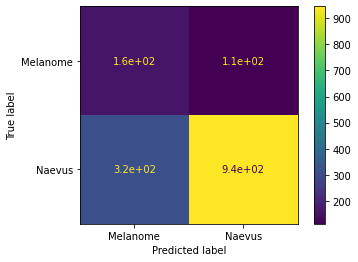

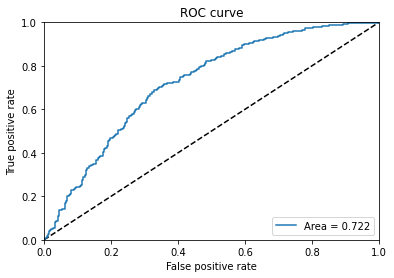

Cross_val_score (auc): 0.7227942752773582


In [ ]:
name = 'M_ColorMean'
featuresNames = [name]

parameters = {
    'C' : (0.01, 0.1, 1),
    'penalty' : ('l1', 'l2')
}
run_and_test(featuresNames, parameters, LinearSVC(class_weight={0:4.59, 1:1}), hasConfidence=True)

Loading features...
GridSeach...
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1674s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1441s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.4s finished


0.7234004664939407
LinearSVC(C=0.1, class_weight={0: 4.59, 1: 1}, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)
Best estimator...
              precision    recall  f1-score   support

    Mélanome       0.35      0.59      0.44       273
      Naevus       0.89      0.76      0.82      1260

    accuracy                           0.73      1533
   macro avg       0.62      0.67      0.63      1533
weighted avg       0.80      0.73      0.76      1533

ROC score on test set :  0.7263503692075121


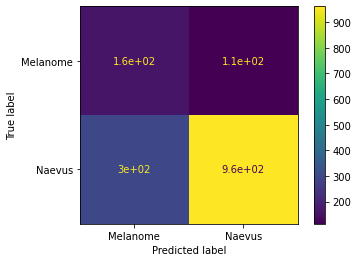

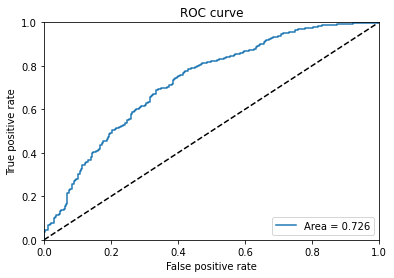

Cross_val_score (auc): 0.7234004664939407


In [ ]:
name = 'color_mean'
featuresNames = [name]

parameters = {
    'C' : (0.01, 0.1, 1),
    'penalty' : ('l1', 'l2')
}
run_and_test(featuresNames, parameters, LinearSVC(class_weight={0:4.59, 1:1}), hasConfidence=True)

In [ ]:
name = 'PCA_color_mean_Lab'
featuresNames = [name]

parameters = {
    'C' : (0.01, 0.1, 1),
    'penalty' : ('l1', 'l2')
}
run_and_test(featuresNames, parameters, LinearSVC(class_weight={0:4.59, 1:1}), hasConfidence=True)

Loading features...
GridSeach...
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1717s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0995s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.5s finished


0.7271102296757073
LinearSVC(C=1, class_weight={0: 4.59, 1: 1}, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)
Best estimator...
              precision    recall  f1-score   support

    Mélanome       0.34      0.60      0.43       273
      Naevus       0.90      0.75      0.81      1260

    accuracy                           0.72      1533
   macro avg       0.62      0.67      0.62      1533
weighted avg       0.80      0.72      0.75      1533

ROC score on test set :  0.7299610442467586


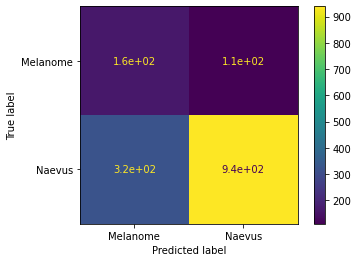

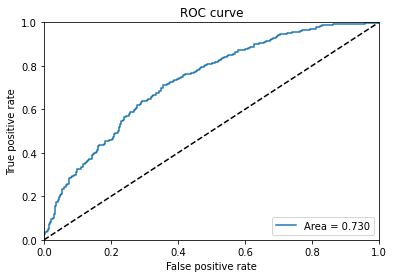

Cross_val_score (auc): 0.7271102296757073


In [ ]:
name = 'PCA_color_mean_HSV'
featuresNames = [name]

parameters = {
    'C' : (0.01, 0.1, 1),
    'penalty' : ('l1', 'l2')
}
run_and_test(featuresNames, parameters, LinearSVC(class_weight={0:4.59, 1:1}), hasConfidence=True)

## Histograms

In [ ]:
# In : Image, quadrants, number of bins
# Out : Color histogram by quadrant, with n_bins
# Results are divided by the total number of pixel in the quadrant
def get_histos(img, quadrants, n_bins=256):
  diviseur = 256/n_bins
  histo = np.zeros((4,3,n_bins))
  n_pixels = np.zeros(4)
  for i in range(quadrants.shape[0]):
    for j in range(quadrants.shape[1]):
      quad_num = int(quadrants[i][j])
      if quad_num != -1:
        for channel in range(3):
          histo[quad_num][channel][int(img[i][j][channel]/diviseur)] += 1
          n_pixels[quad_num] += 1
  return np.asarray([histo[i] / n_pixels[i] for i in range(4)])

# Feature permettant de calculer les différences entre les histogrammes de couleurs
# Prend en entrée l'image, les quadrants de l'image, ainsi que le nombre de bins
# Par défaut, le nombre de bin est de 10
# Les histogrammes sont sur les canaux RGB puis flatten.
# On a une liste de 4 histogrammes, sur lesquels on compare les valeurs entre chaque quadrants
def f_histo(img, quadrants, n_bins=10):
  histos = get_histos(img, quadrants, n_bins=n_bins)
  histos = histos.reshape((4,-1))
  return feature_diff(histos)

### Debug

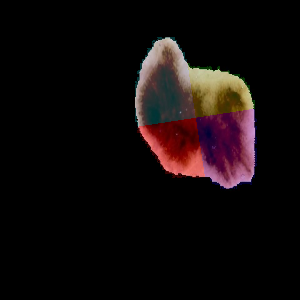

<BarContainer object of 10 artists>

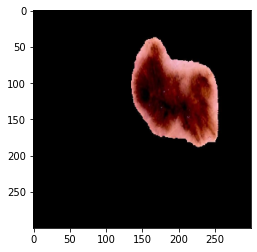

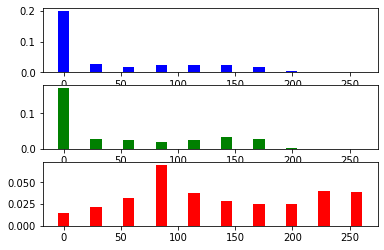

In [ ]:
IMG_SIZE = (300,300)
path = '/content/ISIC_2019/SEGMENTEES/HIGH_RESOL_FILLED/TEST/MEL/ISIC_0000165.JPG'
mask_path = '/content/ISIC_2019/SEGMENTEES/MASK/TEST/MEL/ISIC_0000165_Mask.jpg'
img = cv2.resize(cv2.imread(path), IMG_SIZE)
mask = cv2.resize(cv2.imread(mask_path, 0), IMG_SIZE)
points = np.asarray(get_points(mask))
axe1, axe2 = get_axes(points, method='Minim', mask=mask)
quadrants = make_quadrants(mask, points, axe1, axe2)
res = quad_on_img(img, quadrants, 0.8)
cv2_imshow(res)
histos = get_histos(img, quadrants, n_bins=10)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
fig, axs = plt.subplots(3)
axs[0].bar(np.linspace(0,256,10), histos[0][0], width=10, color='blue')
axs[1].bar(np.linspace(0,256,10), histos[0][1], width=10, color='green')
axs[2].bar(np.linspace(0,256,10), histos[0][2], width=10, color='red')

### Save

BGR

In [ ]:
def get_features(img, mask):
  features = []
  points = np.asarray(get_points(mask))
  center = get_center(points)
  axe1, axe2 = get_axes(points)
  quadrants = make_quadrants(mask, points, axe1, axe2)
  features = f_histo(img, quadrants, n_bins=10)
  return features

path = '/content/drive/MyDrive/Stage_LIS/Features/'

X, y = load_all_data('TRAIN/', verbose=True, get_features=get_features)
np.savetxt(path+'X_train_histos.txt', X)

X, y = load_all_data('TEST/', verbose=True, get_features=get_features)
np.savetxt(path+'X_test_histos.txt', X)

CieLab - Erreur car Lab contient des valeurs négatives qui cassent tout le programme

Edit : Non car les images sont en uint8, donc les range sont bien 0-255

In [ ]:
def get_features(img, mask):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
  features = []
  points = np.asarray(get_points(mask))
  center = get_center(points)
  axe1, axe2 = get_axes(points)
  quadrants = make_quadrants(mask, points, axe1, axe2)
  features = f_histo(img, quadrants, n_bins=10)
  return features

path = '/content/drive/MyDrive/Stage_LIS/Features/'

X, y = load_all_data('TRAIN/', verbose=True, get_features=get_features)
np.savetxt(path+'X_train_histos_Lab.txt', X)

X, y = load_all_data('TEST/', verbose=True, get_features=get_features)
np.savetxt(path+'X_test_histos_Lab.txt', X)

HSV

In [ ]:
def get_features(img, mask):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
  features = []
  points = np.asarray(get_points(mask))
  center = get_center(points)
  axe1, axe2 = get_axes(points)
  quadrants = make_quadrants(mask, points, axe1, axe2)
  features = f_histo(img, quadrants, n_bins=10)
  return features

path = '/content/drive/MyDrive/Stage_LIS/Features/'

X, y = load_all_data('TRAIN/', verbose=True, get_features=get_features)
np.savetxt(path+'X_train_histos_HSV.txt', X)

X, y = load_all_data('TEST/', verbose=True, get_features=get_features)
np.savetxt(path+'X_test_histos_HSV.txt', X)

In [ ]:
def get_features(img, mask):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
  features = []
  points = np.asarray(get_points(mask))
  center = get_center(points)
  axe1, axe2 = get_axes(points)
  quadrants = make_quadrants(mask, points, axe1, axe2)
  features = f_histo(img, quadrants, n_bins=10)
  return features

path = '/content/drive/MyDrive/Stage_LIS/Features/'

X, y = load_all_data('TRAIN/', verbose=True, get_features=get_features)
np.savetxt(path+'X_train_histos_YCrCb.txt', X)

X, y = load_all_data('TEST/', verbose=True, get_features=get_features)
np.savetxt(path+'X_test_histos_YCrCb.txt', X)

1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0
31.0
32.0
33.0
34.0
35.0
36.0
37.0
38.0
39.0
40.0
41.0
42.0
43.0
44.0
45.0
46.0
47.0
48.0
49.0
50.0
51.0
52.0
53.0
54.0
55.0
56.0
57.0
58.0
59.0
60.0
61.0
62.0
63.0
64.0
65.0
66.0
67.0
68.0
69.0
70.0
71.0
72.0
73.0
74.0
75.0
76.0
77.0
78.0
79.0
80.0
81.0
82.0
83.0
84.0
85.0
86.0
87.0
88.0
89.0
90.0
91.0
92.0
93.0
94.0
95.0
96.0
97.0
98.0
99.0
100.0
0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0
31.0
32.0
33.0
34.0
35.0
36.0
37.0
38.0
39.0
40.0
41.0
42.0
43.0
44.0
45.0
46.0
47.0
48.0
49.0
50.0
51.0
52.0
53.0
54.0
55.0
56.0
57.0
58.0
59.0
60.0
61.0
62.0
63.0
64.0
65.0
66.0
67.0
68.0
69.0
70.0
71.0
72.0
73.0
74.0
75.0
76.0
77.0
78.0
79.0
80.0
81.0
82.0
83.0
84.0
85.0
86.0
87.0
88.0
89.0
90.0
91.0
92.0
93.0
94.0
95.0
96.0
97.0
98.0
99.0
100.0
1.0
2.0
3.0


### Results

Loading features...
GridSeach...
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   27.7s finished
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.8056991137143725
LinearSVC(C=0.01, class_weight={0: 4.59, 1: 1}, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)
Best estimator...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

    Mélanome       0.38      0.73      0.50       273
      Naevus       0.93      0.74      0.83      1260

    accuracy                           0.74      1533
   macro avg       0.66      0.74      0.66      1533
weighted avg       0.83      0.74      0.77      1533

ROC score on test set :  0.8161114018256875


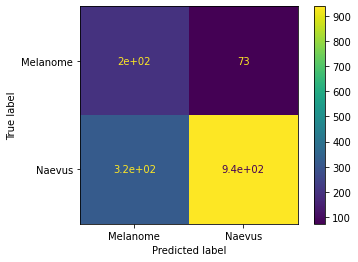

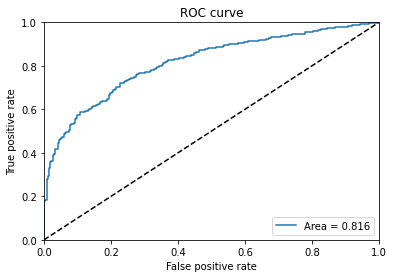

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Cross_val_score (auc): 0.8055937652115739


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [ ]:
featuresNames = ('histos')

parameters = {
    'C' : (0.01, 0.1, 1),
    'penalty' : ('l1', 'l2')
}
run_and_test(featuresNames, parameters, LinearSVC(class_weight={0:4.59, 1:1}), hasConfidence=True)

Loading features...
GridSeach...
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   11.7s finished
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.7046528523248679
LinearSVC(C=0.01, class_weight={0: 4.59, 1: 1}, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)
Best estimator...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

    Mélanome       0.40      0.60      0.48       273
      Naevus       0.90      0.81      0.85      1260

    accuracy                           0.77      1533
   macro avg       0.65      0.70      0.67      1533
weighted avg       0.81      0.77      0.79      1533

ROC score on test set :  0.791095412523984


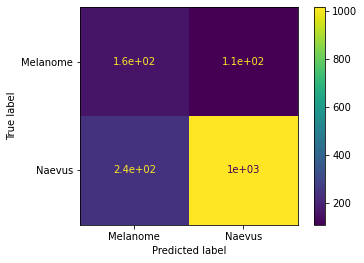

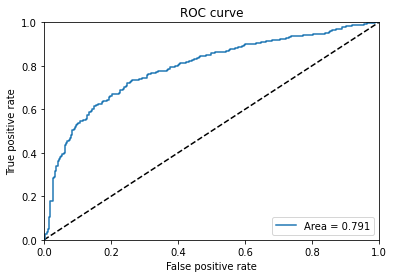

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Cross_val_score (auc): 0.7644359583206854


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [ ]:
featuresNames = ('histos_Lab')

parameters = {
    'C' : (0.01, 0.1, 1),
    'penalty' : ('l1', 'l2')
}
run_and_test(featuresNames, parameters, LinearSVC(class_weight={0:4.59, 1:1}), hasConfidence=True)

Loading features...
GridSeach...
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   16.0s finished
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.7663044279025433
LinearSVC(C=0.01, class_weight={0: 4.59, 1: 1}, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)
Best estimator...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

    Mélanome       0.39      0.69      0.50       273
      Naevus       0.92      0.77      0.84      1260

    accuracy                           0.75      1533
   macro avg       0.65      0.73      0.67      1533
weighted avg       0.83      0.75      0.78      1533

ROC score on test set :  0.8102186173614745


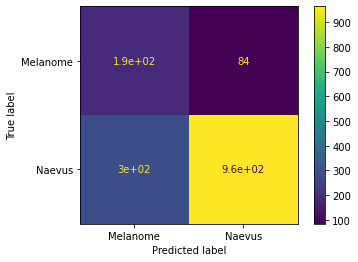

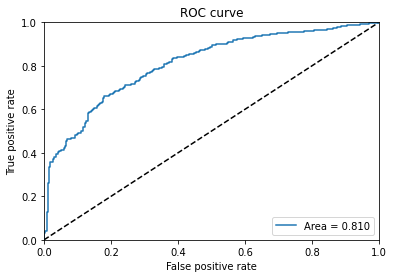

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Cross_val_score (auc): 0.7959043175439444


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [ ]:
featuresNames = ('histos_HSV')

parameters = {
    'C' : (0.01, 0.1, 1),
    'penalty' : ('l1', 'l2')
}
run_and_test(featuresNames, parameters, LinearSVC(class_weight={0:4.59, 1:1}), hasConfidence=True)

Loading features...
GridSeach...
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1876s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1562s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.7s finished


0.8252996103867793
LinearSVC(C=0.01, class_weight={0: 4.59, 1: 1}, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)
Best estimator...
              precision    recall  f1-score   support

    Mélanome       0.37      0.73      0.49       273
      Naevus       0.93      0.73      0.82      1260

    accuracy                           0.73      1533
   macro avg       0.65      0.73      0.65      1533
weighted avg       0.83      0.73      0.76      1533

ROC score on test set :  0.8232426303854875


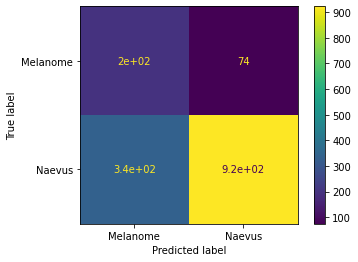

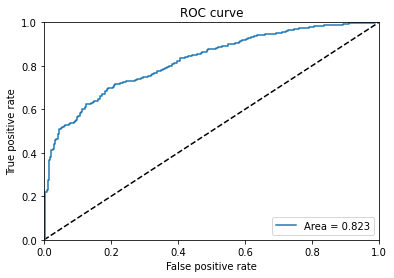

Cross_val_score (auc): 0.8252996103867793


In [ ]:
featuresNames = ('histos_YCrCb')

parameters = {
    'C' : (0.01, 0.1, 1),
    'penalty' : ('l1', 'l2')
}
run_and_test(featuresNames, parameters, LinearSVC(class_weight={0:4.59, 1:1}), hasConfidence=True)

## Superpixels difference sorted by luminosity for each quadrant

In [ ]:
def f_superpixel_diff(images, numSegments=50):
  superpixelise = []
  for image in images:
    segments = slic(image, n_segments = numSegments, sigma = 5, compactness=50)
    out1 = color.label2rgb(segments, image, kind='avg', bg_label=-1)
    superpixelise.append(out1)
  unique_colors = sorted([np.unique(np.reshape(quad, (-1, 3)), axis=0) for quad in superpixelise], key=lambda rgb : np.mean(rgb))
  for i, quad in enumerate(unique_colors):
    while len(unique_colors[i]) < numSegments:
      unique_colors[i] = np.concatenate((unique_colors[i],np.asarray((unique_colors[i][-1]).reshape((1,3)))))
    if len(unique_colors[i]) > 50:
      unique_colors[i] = unique_colors[i][:50]
  unique_colors = np.asarray(unique_colors).reshape((4, -1))
  #return feature_diff(unique_colors)
  diff = np.abs(unique_colors[0] - unique_colors[3], unique_colors[1] - unique_colors[2])
  return list(diff.flatten())

### Debug

### Save

### Results

## Distance and area by luminosity

In [ ]:
# d1 : total d2 : sombre
# aire0 : sombre aire1 : total
def f_distareas(image, full_quads, points):
  ret, thresh = cv2.threshold(image, 85, 255, cv2.THRESH_BINARY)
  feature = []
  center = get_center(points)
  cX = center[0]
  cY = center[1]
  d1 = []
  d2 = []
  centroids = []
  for n_quad in range(4):
    centroids.append(get_hue_centroids(n_quad, full_quads, thresh))

  for quad in centroids:
    d1.append(np.linalg.norm(quad[0] - (cX, cY)))
    d2.append(np.linalg.norm(quad[1] - (cX, cY)))

  areas = get_areas(thresh, full_quads)

  feature = [(areas[i][0] * d2[i]) / (areas[i][1] * d1[i]) for i in range(4)]
  #for i in range(4):
   # feature += (areas[i][0] * d2[i]) / (areas[i][1] * d1[i])

  return scalar_feature_diff(feature)

### Debug

### Save

### Results

## Angles of dark centroids by quadrants

In [ ]:
# Angles entre les centroids de teintes sombre
def f_lum_angles(image, full_quads, points):
  ret, thresh = cv2.threshold(image, 85, 255, cv2.THRESH_BINARY)
  feature = []
  center = get_center(points)
  cX = center[0]
  cY = center[1]
  centroids = []
  for n_quad in range(4):
    centroids.append(get_hue_centroids(n_quad, full_quads, thresh))

  angles = []

  for quad in centroids:
    ba = quad[0] - center
    bc = quad[1] - center
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angles.append(np.abs(np.arccos(round(cosine_angle, 2))))
  return scalar_feature_diff(angles)

### Debug

### Save

### Results

## Mean color of superpixels on circles

In [ ]:
quadcolor = ['red', 'blue', 'green', 'yellow', 'black']

def f_superpixel_circles(img, center, full_quads, numSegments=50, n_circles=4):
  segments = slic(img, n_segments = numSegments, sigma = 5)
  img2 = color.label2rgb(segments, img, kind='avg', bg_label=-1)
  feature = []
  cX, cY = center
  radius = get_radius_list((cY, cX), full_quads, n_circles)
  for rad in radius:
    somme = np.zeros((4, 3))
    nb_pixels = np.zeros(4)
    for i, row in enumerate(img2):
      for j, pixel in enumerate(row):
        if int(distance((i,j), (cX, cY))) == int(rad):
          quad_num = int(full_quads[j][i])
          somme[quad_num] += pixel
          nb_pixels[quad_num] += 1
          #plt.scatter(i,j, c=quadcolor[quad_num])

    if 0 in nb_pixels:
      print('Warning : missing pixel values')
    somme = [somme[i] / nb_pixels[i] if 0 != nb_pixels[i]
             else np.mean(img2, axis=(0,1), dtype=int)
             for i in range(somme.shape[0])]
    feature += feature_diff(somme)
  return feature

### Debug

[36.929662077597, 30.528101793909045, 17.622277847309135, 31.200000000000003, 27.379999999999995, 16.799999999999997, 26.476595744680843, 22.449148936170204, 13.417021276595747, 55.85998131891749, 44.44228611813719, 25.981432698507163, 51.37742812742813, 42.67132867132867, 25.109411421911418, 46.32217560217559, 37.24201048951049, 20.694032634032624, 84.20293889775712, 68.24354200321898, 39.768039296848514, 58.96654158849282, 46.721701063164474, 26.681676047529706, 39.401427869758095, 30.650283798265427, 17.093822948511317, 17.086893749198964, 12.354805147807213, 10.49172566138165, 16.961538461538467, 11.593117408906892, 7.672064777327947, 13.245352045778404, 8.602624416649704, 5.099953633546676]


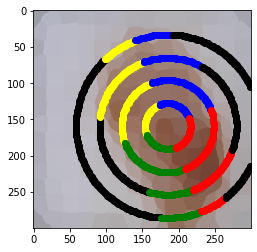

In [ ]:
from skimage import color

quadcolor = ['red', 'blue', 'green', 'yellow', 'black']

def f_superpixel_circles_debug(img, center, full_quads, numSegments=50, n_circles=4):
  segments = slic(img, n_segments = numSegments, sigma = 5)
  img2 = color.label2rgb(segments, img, kind='avg', bg_label=-1)
  feature = []
  cX, cY = center
  radius = get_radius_list((cY, cX), full_quads, n_circles)
  for rad in radius:
    somme = np.zeros((4, 3))
    nb_pixels = np.zeros(4)
    for i, row in enumerate(img2):
      for j, pixel in enumerate(row):
        if int(distance((i,j), (cX, cY))) == int(rad):
          quad_num = int(full_quads[j][i])
          somme[quad_num] += pixel
          nb_pixels[quad_num] += 1
          plt.scatter(i,j, c=quadcolor[quad_num])

    if 0 in nb_pixels:
      print('Warning : missing pixel values')
    somme = [somme[i] / nb_pixels[i] if 0 != nb_pixels[i]
             else np.mean(img2, axis=(0,1), dtype=int)
             for i in range(somme.shape[0])]
    feature += feature_diff(somme)
  return feature

path = '/content/ISIC_2019/NON_SEGMENTEES/TRAIN/NEV/ISIC_0000055_downsampled.JPG'
mask_path = '/content/ISIC_2019/SEGMENTEES/MASK/TRAIN/NEV/ISIC_0000055_downsampled_Mask.jpg'
img = cv2.resize(cv2.imread(path), (300,300))
mask = cv2.resize(cv2.imread(mask_path, 0), (300,300))
features = []
points = np.asarray(get_points(mask))
cX, cY = get_center(points)
axe1, axe2 = get_axes(points)
quadrants = make_quadrants(mask, points, axe1, axe2)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
feature = f_superpixel_circles_debug(img, (cX, cY), quadrants)
plt.gca().set_aspect('equal', adjustable='box')
print(feature)
segments = slic(img, n_segments = 200, sigma = 5)
img2 = skimage.color.label2rgb(segments, img, kind='avg', bg_label=-1)
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))

### Save

In [ ]:
def get_features(img, mask):
  features = []
  points = np.asarray(get_points(mask))
  center = get_center(points)
  axe1, axe2 = get_axes(points)
  quadrants = make_quadrants(mask, points, axe1, axe2)
  features = f_superpixel_circles(img, center, quadrants, n_circles=4)
  return features

path = '/content/drive/MyDrive/Stage_LIS/Features/'

X, y = load_all_data('TRAIN/', verbose=True, get_features=get_features)
np.savetxt(path+'X_train_SPPQ_4.txt', X)

X, y = load_all_data('TEST/', verbose=True, get_features=get_features)
np.savetxt(path+'X_test_SPPQ_4.txt', X)

1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0
31.0
32.0
33.0
34.0
35.0
36.0
37.0
38.0
39.0
40.0
41.0
42.0
43.0
44.0
45.0
46.0
47.0
48.0
49.0
50.0
51.0
52.0
53.0
54.0
55.0
56.0
57.0
58.0
59.0
60.0
61.0
62.0
63.0
64.0
65.0
66.0
67.0
68.0
69.0
70.0
71.0
72.0
73.0
74.0
75.0
76.0
77.0
78.0
79.0
80.0
81.0
82.0
83.0
84.0
85.0
86.0
87.0
88.0
89.0
90.0
91.0
92.0
93.0
94.0
95.0
96.0
97.0
98.0
99.0
100.0
0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0
31.0
32.0
33.0
34.0
35.0
36.0
37.0
38.0
39.0
40.0
41.0
42.0
43.0
44.0
45.0
46.0
47.0
48.0
49.0
50.0
51.0
52.0
53.0
54.0
55.0
56.0
57.0
58.0
59.0
60.0
61.0
62.0
63.0
64.0
65.0
66.0
67.0
68.0


### Results

## Color difference between circles and lines intersections by quadrants

In [ ]:
def f_superpixel_circles_new(img, center, axes, full_quads, numSegments=200, n_circles=2, n_lines=1):
  IMG_SIZE = img.shape[0]
  segments = slic(img, n_segments = numSegments, sigma = 5)
  img2 = skimage.color.label2rgb(segments, img, kind='avg', bg_label=-1)
  feature = []
  cX, cY = center
  radius_list = get_radius_list((cY, cX), full_quads, n_circles)
  newAxes = toLongLines(axes, max(radius_list), (cX, cY))
  line_list = get_line_list((cY, cX), newAxes, n_lines)
  for num_rad, radius in enumerate(radius_list):
    circle_tmp = []
    line_list = get_line_list((cY, cX), newAxes, n_lines+num_rad)
    for line in line_list:
      p = Point(cX, cY)
      c = p.buffer(radius).boundary
      l = LineString(line)
      #plt.scatter(np.asarray(c.coords)[:,0], np.asarray(c.coords)[:,1], s=1)
      #plot_line(line)
      i = c.intersection(l)
      p1 = i.geoms[0].coords[0]
      p2 = i.geoms[1].coords[0]
      p1 = [int(i) for i in p1]
      p2 = [int(i) for i in p2]
      #plt.scatter((p1[0], p2[0]), (p1[1], p2[1]))
      if (np.asarray(p1) >= IMG_SIZE).any() and (np.asarray(p2) >= IMG_SIZE).any():
        a = np.asarray(np.asarray((0,0,0), dtype=np.int16))
        b = np.asarray(np.asarray((0,0,0), dtype=np.int16))
      elif (np.asarray(p1) >= IMG_SIZE).any():
        a = np.asarray(np.asarray((0,0,0), dtype=np.int16))
        b = np.asarray(img2[p2[1]][p2[0]], dtype=np.int16)
      elif (np.asarray(p2) >= IMG_SIZE).any():
        a = np.asarray(img2[p1[1]][p1[0]], dtype=np.int16)
        b = np.asarray(np.asarray((0,0,0), dtype=np.int16))
      else:
        a = np.asarray(img2[p1[1]][p1[0]], dtype=np.int16)
        b = np.asarray(img2[p2[1]][p2[0]], dtype=np.int16)
      circle_tmp.append(np.abs(a-b))
    feature.append(np.mean(circle_tmp, axis=0))
  #return np.asarray(feature).flatten()
  #return np.mean(np.asarray(feature).reshape((-1,3)), axis=0)
  return np.asarray(feature).flatten()

### Variantes

Version sans la moyenne mais avec les valeurs ordonnées

In [ ]:
def SPCO(img, center, axes, full_quads, numSegments=200, n_circles=2, n_lines=1):
  IMG_SIZE = img.shape[0]
  segments = slic(img, n_segments = numSegments, sigma = 5)
  img2 = skimage.color.label2rgb(segments, img, kind='avg', bg_label=-1)
  feature = []
  cX, cY = center
  radius_list = get_radius_list((cY, cX), full_quads, n_circles)
  newAxes = toLongLines(axes, max(radius_list), (cX, cY))
  line_list = get_line_list((cY, cX), newAxes, n_lines)
  for num_rad, radius in enumerate(radius_list):
    line_list = get_line_list((cY, cX), newAxes, n_lines+num_rad)
    for line in line_list:
      p = Point(cX, cY)
      c = p.buffer(radius).boundary
      l = LineString(line)
      #plt.scatter(np.asarray(c.coords)[:,0], np.asarray(c.coords)[:,1], s=1)
      #plot_line(line)
      i = c.intersection(l)
      p1 = i.geoms[0].coords[0]
      p2 = i.geoms[1].coords[0]
      p1 = [int(i) for i in p1]
      p2 = [int(i) for i in p2]
      #plt.scatter((p1[0], p2[0]), (p1[1], p2[1]))
      if (np.asarray(p1) >= IMG_SIZE).any() and (np.asarray(p2) >= IMG_SIZE).any():
        a = np.asarray(np.asarray((0,0,0), dtype=np.int16))
        b = np.asarray(np.asarray((0,0,0), dtype=np.int16))
      elif (np.asarray(p1) >= IMG_SIZE).any():
        a = np.asarray(np.asarray((0,0,0), dtype=np.int16))
        b = np.asarray(img2[p2[1]][p2[0]], dtype=np.int16)
      elif (np.asarray(p2) >= IMG_SIZE).any():
        a = np.asarray(img2[p1[1]][p1[0]], dtype=np.int16)
        b = np.asarray(np.asarray((0,0,0), dtype=np.int16))
      else:
        a = np.asarray(img2[p1[1]][p1[0]], dtype=np.int16)
        b = np.asarray(img2[p2[1]][p2[0]], dtype=np.int16)
      feature.append(np.abs(a-b))
  #return np.asarray(feature).flatten()
  #return np.mean(np.asarray(feature).reshape((-1,3)), axis=0)
  return np.asarray(sorted(feature, key= lambda x: np.mean(x))).flatten()

Une ligne tous les 60 degrés

In [ ]:
def SP60(img, center, axes, full_quads, numSegments=200, n_circles=2):
  IMG_SIZE = img.shape[0]
  segments = slic(img, n_segments = numSegments, sigma = 5)
  img2 = skimage.color.label2rgb(segments, img, kind='avg', bg_label=-1)
  feature = []
  cX, cY = center
  radius_list = get_radius_list((cY, cX), full_quads, n_circles)
  newAxes = toLongLines(axes, max(radius_list), (cX, cY))
  line_list = get_line_list_60((cY, cX), newAxes)
  for num_rad, radius in enumerate(radius_list):
    circle_tmp = []
    line_list = get_line_list_60((cY, cX), newAxes)
    for line in line_list:
      p = Point(cX, cY)
      c = p.buffer(radius).boundary
      l = LineString(line)
      #plt.scatter(np.asarray(c.coords)[:,0], np.asarray(c.coords)[:,1], s=1)
      #plot_line(line)
      i = c.intersection(l)
      p1 = i.geoms[0].coords[0]
      p2 = i.geoms[1].coords[0]
      p1 = [int(i) for i in p1]
      p2 = [int(i) for i in p2]
      #plt.scatter((p1[0], p2[0]), (p1[1], p2[1]))
      if (np.asarray(p1) >= IMG_SIZE).any() and (np.asarray(p2) >= IMG_SIZE).any():
        a = np.asarray(np.asarray((0,0,0), dtype=np.int16))
        b = np.asarray(np.asarray((0,0,0), dtype=np.int16))
      elif (np.asarray(p1) >= IMG_SIZE).any():
        a = np.asarray(np.asarray((0,0,0), dtype=np.int16))
        b = np.asarray(img2[p2[1]][p2[0]], dtype=np.int16)
      elif (np.asarray(p2) >= IMG_SIZE).any():
        a = np.asarray(img2[p1[1]][p1[0]], dtype=np.int16)
        b = np.asarray(np.asarray((0,0,0), dtype=np.int16))
      else:
        a = np.asarray(img2[p1[1]][p1[0]], dtype=np.int16)
        b = np.asarray(img2[p2[1]][p2[0]], dtype=np.int16)
      circle_tmp.append(np.abs(a-b))
    feature.append(np.mean(circle_tmp, axis=0))
  #return np.asarray(feature).flatten()
  #return np.mean(np.asarray(feature).reshape((-1,3)), axis=0)
  return np.asarray(feature).flatten()

In [ ]:
def SP60_nomean(img, center, axes, full_quads, numSegments=200, n_circles=2):
  IMG_SIZE = img.shape[0]
  segments = slic(img, n_segments = numSegments, sigma = 5)
  img2 = skimage.color.label2rgb(segments, img, kind='avg', bg_label=-1)
  feature = []
  cX, cY = center
  radius_list = get_radius_list((cY, cX), full_quads, n_circles)
  newAxes = toLongLines(axes, max(radius_list), (cX, cY))
  line_list = get_line_list_60((cY, cX), newAxes)
  for num_rad, radius in enumerate(radius_list):
    for line in line_list:
      p = Point(cX, cY)
      c = p.buffer(radius).boundary
      l = LineString(line)
      #plt.scatter(np.asarray(c.coords)[:,0], np.asarray(c.coords)[:,1], s=1)
      #plot_line(line)
      i = c.intersection(l)
      p1 = i.geoms[0].coords[0]
      p2 = i.geoms[1].coords[0]
      p1 = [int(i) for i in p1]
      p2 = [int(i) for i in p2]
      #plt.scatter((p1[0], p2[0]), (p1[1], p2[1]))
      if (np.asarray(p1) >= IMG_SIZE).any() and (np.asarray(p2) >= IMG_SIZE).any():
        a = np.asarray(np.asarray((0,0,0), dtype=np.int16))
        b = np.asarray(np.asarray((0,0,0), dtype=np.int16))
      elif (np.asarray(p1) >= IMG_SIZE).any():
        a = np.asarray(np.asarray((0,0,0), dtype=np.int16))
        b = np.asarray(img2[p2[1]][p2[0]], dtype=np.int16)
      elif (np.asarray(p2) >= IMG_SIZE).any():
        a = np.asarray(img2[p1[1]][p1[0]], dtype=np.int16)
        b = np.asarray(np.asarray((0,0,0), dtype=np.int16))
      else:
        a = np.asarray(img2[p1[1]][p1[0]], dtype=np.int16)
        b = np.asarray(img2[p2[1]][p2[0]], dtype=np.int16)
      feature.append(np.abs(a-b))
  #return np.asarray(feature).flatten()
  #return np.mean(np.asarray(feature).reshape((-1,3)), axis=0)
  return np.asarray(feature).flatten()

Par quadrants

In [ ]:
def f_superpixel_circles_quad(img, center, axes, full_quads, numSegments=200, n_circles=2, n_lines=1):
  IMG_SIZE = img.shape[0]
  segments = slic(img, n_segments = numSegments, sigma = 5)
  img2 = skimage.color.label2rgb(segments, img, kind='avg', bg_label=-1)
  feature = []
  somme = np.zeros((4, 3))
  nb_pixels = np.zeros(4)
  cX, cY = center
  radius_list = get_radius_list((cY, cX), full_quads, n_circles)
  newAxes = toLongLines(axes, max(radius_list), (cX, cY))
  line_list = get_line_list((cY, cX), newAxes, n_lines)
  for num_rad, radius in enumerate(radius_list):
    circle_tmp = []
    line_list = get_line_list((cY, cX), newAxes, n_lines+num_rad)
    for line in line_list:
      p = Point(cX, cY)
      c = p.buffer(radius).boundary
      l = LineString(line)
      #plt.scatter(np.asarray(c.coords)[:,0], np.asarray(c.coords)[:,1], s=1)
      #plot_line(line)
      i = c.intersection(l)
      p1 = i.geoms[0].coords[0]
      p2 = i.geoms[1].coords[0]
      p1 = [int(i) for i in p1]
      p2 = [int(i) for i in p2]
      #plt.scatter((p1[0], p2[0]), (p1[1], p2[1]))
      if (np.asarray(p1) >= IMG_SIZE).any() and (np.asarray(p2) >= IMG_SIZE).any():
        a = np.asarray(np.asarray((0,0,0), dtype=np.int16))
        b = np.asarray(np.asarray((0,0,0), dtype=np.int16))
      elif (np.asarray(p1) >= IMG_SIZE).any():
        a = np.asarray(np.asarray((0,0,0), dtype=np.int16))
        b = np.asarray(img2[p2[1]][p2[0]], dtype=np.int16)
      elif (np.asarray(p2) >= IMG_SIZE).any():
        a = np.asarray(img2[p1[1]][p1[0]], dtype=np.int16)
        b = np.asarray(np.asarray((0,0,0), dtype=np.int16))
      else:
        a = np.asarray(img2[p1[1]][p1[0]], dtype=np.int16)
        b = np.asarray(img2[p2[1]][p2[0]], dtype=np.int16)
      circle_tmp.append(np.abs(a-b))
    feature.append(np.mean(circle_tmp, axis=0))
  #return np.asarray(feature).flatten()
  #return np.mean(np.asarray(feature).reshape((-1,3)), axis=0)
  return np.asarray(feature).flatten()

### Functions

In [ ]:
# Renvoie la liste de rayons
# Je fais un rayon en plus, et je jete le plus grand qui ne contient qu'un pixel
def get_radius_list(center, img, n_circles):
  max = 0
  for i, row in enumerate(img):
    for j, quad in enumerate(row):
      if quad != -1:
        dist = distance((i, j), (center[1], center[0]))
        if dist > max:
          max = dist
  return [max/(n_circles+1)*i for i in range(1,n_circles+1)]


# Les 4 axes de base, créés à partir des deux vecteurs
def get_axes_list(axes):
  axes = np.asarray(axes)
  return axes[0], -axes[1], -axes[0], axes[1]


def rotate_point(point, degrees, center):
  degrees = math.radians(degrees)
  s = sin(degrees)
  c = cos(degrees)

  pt = point.copy()
  
  pt[0] -= center[1]
  pt[1] -= center[0]
  newX = pt[0] * c - pt[1] * s
  newY = pt[0] * s + pt[1] * c
  pt[0] = newX + center[1]
  pt[1] = newY + center[0]
  return pt

def rotate_axe(axe, degrees, center):
  return [rotate_point(point, degrees, center) for point in axe]
  #return rotate_point(axe[0], degrees, center), rotate_point(axe[1], -degrees, center)

def toLongLine(line, radius, center):
  newLine = []
  a = line[0]
  b = line[1]
  lenLine = sqrt(pow(a[0] - b[0], 2) + pow(a[1] - b[1], 2))
  newLine.append(a - (b - a) / lenLine * radius)
  newLine.append((center[0], center[1]) + (b - a) / lenLine * radius)
  return newLine

def toLongLines(axes, radius, center):
  return [toLongLine(axe, radius, center) for axe in axes]

# Ici, il faut calculer les axes qui passent par le centre de la lésion
# Selon leur nombre par quadrant, il faut calculer l'angle
# Qui les sépare, puis leur vecteur directeur en fonction du centre
# De la lésion
def get_line_list(center, axes, n_lines):
  #plot_lines(axes)
  line_list = []
  degreeToMove = 90./(n_lines+1)
  for axe in axes:
    for i in range(0,n_lines+1):
      #plot_line(rotate_axe(axe, degreeToMove*i, center))
      value = rotate_axe(axe, degreeToMove*i, center)
      line_list.append(np.asarray(value))
  return np.asarray(line_list)

def distance(p1, p2):
  return np.sqrt(pow(p1[0]-p2[0],2) + pow(p1[1]-p2[1], 2))

def plot_line(line):
  l = LineString(line)
  plt.plot(np.asarray(l.coords)[:,0], np.asarray(l.coords)[:,1])

def plot_lines(lines):
  for line in lines:
      plot_line(line)


def get_line_list_60(center, axes):
  #plot_lines(axes)
  line_list = []
  degreeToMove = 60
  axe = axes[0]
  for i in range(0,3):
    #plot_line(rotate_axe(axe, degreeToMove*i, center))
    value = rotate_axe(axe, degreeToMove*i, center)
    line_list.append(np.asarray(value))
  return np.asarray(line_list)

### Debug

[[166, 110], [203, 208], [163, 207], [206, 111], [136, 178], [234, 140], [137, 137], [233, 180], [147, 61], [222, 257], [168, 263], [201, 55], [118, 241], [251, 77], [87, 196], [283, 121], [81, 142], [288, 175], [103, 93], [266, 225]]
[41 36 22  1  5  5 21 16  5 23 23 18 32 24 14 24 19  8  8  8  6  9 11 12
 13 11 14 32 20  7]


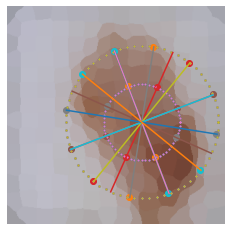

In [ ]:
def f_superpixel_circles_new_debug(img, center, axes, full_quads, numSegments=200, n_circles=2, n_lines=1):
  toutlespoints = []
  segments = slic(img, n_segments = numSegments, sigma = 5)
  img2 = skimage.color.label2rgb(segments, img, kind='avg', bg_label=-1)
  feature = []
  cX, cY = center
  radius_list = get_radius_list((cY, cX), full_quads, n_circles)
  newAxes = toLongLines(axes, max(radius_list), (cX, cY))
  plot_lines(newAxes)
  #line_list = get_line_list((cY, cX), newAxes, n_lines)
  for num_rad, radius in enumerate(radius_list):
    line_list = get_line_list((cY, cX), newAxes, n_lines+num_rad)
    for line in line_list:
      p = Point(cX, cY)
      c = p.buffer(radius).boundary
      l = LineString(line)
      i = c.intersection(l)
      plt.scatter(np.asarray(c.coords)[:,0], np.asarray(c.coords)[:,1], s=1)
      plot_line(line)
      p1 = i.geoms[0].coords[0]
      p2 = i.geoms[1].coords[0]
      p1 = [int(i) for i in p1]
      p2 = [int(i) for i in p2]
      toutlespoints.append(p1)
      toutlespoints.append(p2)
      plt.scatter((p1[0], p2[0]), (p1[1], p2[1]))
      if (np.asarray(p1) >= 300).any() or (np.asarray(p2) >= 300).any():
        feature.append(np.asarray((0,0,0), dtype=np.uint8))
      else:
        a = np.asarray(img2[p1[1]][p1[0]], dtype=np.int16)
        b = np.asarray(img2[p2[1]][p2[0]], dtype=np.int16)
        feature.append(np.abs(a-b))
  print(toutlespoints)
  return np.asarray(feature).flatten()

path = '/content/ISIC_2019/NON_SEGMENTEES/TRAIN/NEV/ISIC_0000055_downsampled.JPG'
mask_path = '/content/ISIC_2019/SEGMENTEES/MASK/TRAIN/NEV/ISIC_0000055_downsampled_Mask.jpg'
img = cv2.resize(cv2.imread(path), (300,300))
mask = cv2.resize(cv2.imread(mask_path, 0), (300,300))
features = []
points = np.asarray(get_points(mask))
cX, cY = get_center(points)
axe1, axe2 = get_axes(points)
quadrants = make_quadrants(mask, points, axe1, axe2)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
feature = f_superpixel_circles_new_debug(img, (cX, cY), (axe1, axe2), quadrants)
plt.gca().set_aspect('equal', adjustable='box')
print(feature)
segments = slic(img, n_segments = 200, sigma = 5)
img2 = skimage.color.label2rgb(segments, img, kind='avg', bg_label=-1)
plt.axis('off')
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))

[26.33333333 24.33333333 17.33333333 17.66666667 14.33333333 11.33333333]


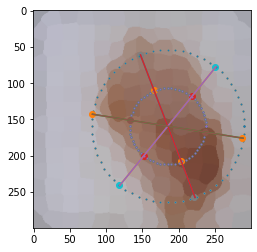

In [ ]:
def SP60_debug(img, center, axes, full_quads, numSegments=200, n_circles=2):
  IMG_SIZE = img.shape[0]
  segments = slic(img, n_segments = numSegments, sigma = 5)
  img2 = skimage.color.label2rgb(segments, img, kind='avg', bg_label=-1)
  feature = []
  cX, cY = center
  radius_list = get_radius_list((cY, cX), full_quads, n_circles)
  newAxes = toLongLines(axes, max(radius_list), (cX, cY))
  line_list = get_line_list_60((cY, cX), newAxes)
  for num_rad, radius in enumerate(radius_list):
    circle_tmp = []
    line_list = get_line_list_60((cY, cX), newAxes)
    for line in line_list:
      p = Point(cX, cY)
      c = p.buffer(radius).boundary
      l = LineString(line)
      plt.scatter(np.asarray(c.coords)[:,0], np.asarray(c.coords)[:,1], s=1)
      plot_line(line)
      i = c.intersection(l)
      p1 = i.geoms[0].coords[0]
      p2 = i.geoms[1].coords[0]
      p1 = [int(i) for i in p1]
      p2 = [int(i) for i in p2]
      plt.scatter((p1[0], p2[0]), (p1[1], p2[1]))
      if (np.asarray(p1) >= IMG_SIZE).any() and (np.asarray(p2) >= IMG_SIZE).any():
        a = np.asarray(np.asarray((0,0,0), dtype=np.int16))
        b = np.asarray(np.asarray((0,0,0), dtype=np.int16))
      elif (np.asarray(p1) >= IMG_SIZE).any():
        a = np.asarray(np.asarray((0,0,0), dtype=np.int16))
        b = np.asarray(img2[p2[1]][p2[0]], dtype=np.int16)
      elif (np.asarray(p2) >= IMG_SIZE).any():
        a = np.asarray(img2[p1[1]][p1[0]], dtype=np.int16)
        b = np.asarray(np.asarray((0,0,0), dtype=np.int16))
      else:
        a = np.asarray(img2[p1[1]][p1[0]], dtype=np.int16)
        b = np.asarray(img2[p2[1]][p2[0]], dtype=np.int16)
      circle_tmp.append(np.abs(a-b))
    feature.append(np.mean(circle_tmp, axis=0))
  #return np.asarray(feature).flatten()
  #return np.mean(np.asarray(feature).reshape((-1,3)), axis=0)
  return np.asarray(feature).flatten()

path = '/content/ISIC_2019/NON_SEGMENTEES/TRAIN/NEV/ISIC_0000055_downsampled.JPG'
mask_path = '/content/ISIC_2019/SEGMENTEES/MASK/TRAIN/NEV/ISIC_0000055_downsampled_Mask.jpg'
img = cv2.resize(cv2.imread(path), (300,300))
mask = cv2.resize(cv2.imread(mask_path, 0), (300,300))
features = []
points = np.asarray(get_points(mask))
cX, cY = get_center(points)
axe1, axe2 = get_axes(points)
quadrants = make_quadrants(mask, points, axe1, axe2)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
feature = SP60_debug(img, (cX, cY), (axe1, axe2), quadrants)
plt.gca().set_aspect('equal', adjustable='box')
print(feature)
segments = slic(img, n_segments = 200, sigma = 5)
img2 = skimage.color.label2rgb(segments, img, kind='avg', bg_label=-1)
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))

### Save

In [ ]:
def get_features(img, mask):
  features = []
  points = np.asarray(get_points(mask))
  center = get_center(points)
  axe1, axe2 = get_axes(points)
  quadrants = make_quadrants(mask, points, axe1, axe2)
  features = f_superpixel_circles_new(img, center, (axe1, axe2), quadrants, n_circles=5, n_lines=3)
  return features

path = '/content/drive/MyDrive/Stage_LIS/Features/'

X, y = load_all_data('TRAIN/', verbose=True, get_features=get_features)
np.savetxt(path+'X_train_SPML_5_3.txt', X)

X, y = load_all_data('TEST/', verbose=True, get_features=get_features)
np.savetxt(path+'X_test_SPML_5_3.txt', X)

In [ ]:
def get_features(img, mask):
  features = []
  points = np.asarray(get_points(mask))
  center = get_center(points)
  axe1, axe2 = get_axes(points)
  quadrants = make_quadrants(mask, points, axe1, axe2)
  features = SPCO(img, center, (axe1, axe2), quadrants, n_circles=4, n_lines=2)
  return features

path = '/content/drive/MyDrive/Stage_LIS/Features/'

X, y = load_all_data('TRAIN/', verbose=True, get_features=get_features)
np.savetxt(path+'X_train_SPCO_4_2.txt', X)

X, y = load_all_data('TEST/', verbose=True, get_features=get_features)
np.savetxt(path+'X_test_SPCO_4_2.txt', X)

In [ ]:
def get_features(img, mask):
  features = []
  points = np.asarray(get_points(mask))
  center = get_center(points)
  axe1, axe2 = get_axes(points)
  quadrants = make_quadrants(mask, points, axe1, axe2)
  features = SP60(img, center, (axe1, axe2), quadrants, n_circles=4)
  return features

path = '/content/drive/MyDrive/Stage_LIS/Features/'

X, y = load_all_data('TRAIN/', verbose=True, get_features=get_features)
np.savetxt(path+'X_train_SP60_4.txt', X)

X, y = load_all_data('TEST/', verbose=True, get_features=get_features)
np.savetxt(path+'X_test_SP60_4.txt', X)

In [ ]:
def get_features(img, mask):
  features = []
  points = np.asarray(get_points(mask))
  center = get_center(points)
  axe1, axe2 = get_axes(points)
  quadrants = make_quadrants(mask, points, axe1, axe2)
  features = SP60_nomean(img, center, (axe1, axe2), quadrants, n_circles=4)
  return features

path = '/content/drive/MyDrive/Stage_LIS/Features/'

X, y = load_all_data('TRAIN/', verbose=True, get_features=get_features)
np.savetxt(path+'X_train_SP60_nomean_4.txt', X)

X, y = load_all_data('TEST/', verbose=True, get_features=get_features)
np.savetxt(path+'X_test_SP60_nomean_4.txt', X)

In [ ]:
def get_features(img, mask):
  new_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
  features = []
  points = np.asarray(get_points(mask))
  center = get_center(points)
  axe1, axe2 = get_axes(points)
  quadrants = make_quadrants(mask, points, axe1, axe2)
  features = f_superpixel_circles_new(new_img, center, (axe1, axe2), quadrants, n_circles=4, n_lines=2)
  return features

path = '/content/drive/MyDrive/Stage_LIS/Features/'

X, y = load_all_data('TRAIN/', verbose=True, get_features=get_features)
np.savetxt(path+'X_train_SPML_4_2_HSV.txt', X)

X, y = load_all_data('TEST/', verbose=True, get_features=get_features)
np.savetxt(path+'X_test_SPML_4_2_HSV.txt', X)

In [ ]:
def get_features(img, mask):
  new_img = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
  features = []
  points = np.asarray(get_points(mask))
  center = get_center(points)
  axe1, axe2 = get_axes(points)
  quadrants = make_quadrants(mask, points, axe1, axe2)
  features = f_superpixel_circles_new(new_img, center, (axe1, axe2), quadrants, n_circles=4, n_lines=2)
  return features

path = '/content/drive/MyDrive/Stage_LIS/Features/'

X, y = load_all_data('TRAIN/', verbose=True, get_features=get_features)
np.savetxt(path+'X_train_SPML_4_2_cielab.txt', X)

X, y = load_all_data('TEST/', verbose=True, get_features=get_features)
np.savetxt(path+'X_test_SPML_4_2_cielab.txt', X)

In [ ]:
def get_features(img, mask):
  new_img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
  features = []
  points = np.asarray(get_points(mask))
  center = get_center(points)
  axe1, axe2 = get_axes(points)
  quadrants = make_quadrants(mask, points, axe1, axe2)
  features = f_superpixel_circles_new(new_img, center, (axe1, axe2), quadrants, n_circles=4, n_lines=2)
  return features

path = '/content/drive/MyDrive/Stage_LIS/Features/'

X, y = load_all_data('TRAIN/', verbose=True, get_features=get_features)
np.savetxt(path+'X_train_SPML_4_2_ycbcr.txt', X)

X, y = load_all_data('TEST/', verbose=True, get_features=get_features)
np.savetxt(path+'X_test_SPML_4_2_ycbcr.txt', X)

1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0
31.0
32.0
33.0
34.0
35.0
36.0
37.0
38.0
39.0
40.0
41.0
42.0
43.0
44.0
45.0
46.0
47.0
48.0
49.0
50.0
51.0
52.0
53.0
54.0
55.0
56.0
57.0
58.0
59.0
60.0
61.0
62.0
63.0
64.0
65.0
66.0
67.0
68.0
69.0
70.0
71.0
72.0
73.0
74.0
75.0
76.0
77.0
78.0
79.0
80.0
81.0
82.0
83.0
84.0
85.0
86.0
87.0
88.0
89.0
90.0
91.0
92.0
93.0
94.0
95.0
96.0
97.0
98.0
99.0
100.0
0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0
31.0
32.0
33.0
34.0
35.0
36.0
37.0
38.0
39.0
40.0
41.0
42.0
43.0
44.0
45.0
46.0
47.0
48.0
49.0
50.0
51.0
52.0
53.0
54.0
55.0
56.0
57.0
58.0
59.0
60.0
61.0
62.0
63.0
64.0
65.0
66.0
67.0
68.0
69.0
70.0
71.0
72.0
73.0
74.0
75.0
76.0
77.0
78.0
79.0
80.0
81.0
82.0
83.0
84.0
85.0
86.0
87.0
88.0
89.0
90.0
91.0
92.0
93.0
94.0
95.0
96.0
97.0
98.0
99.0
100.0
1.0
2.0
3.0


### Results

Loading features...
GridSeach...
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0119s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0420s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0873s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.7s finished


0.7965385683067376
LinearSVC(C=1, class_weight={0: 4.59, 1: 1}, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)
Best estimator...
              precision    recall  f1-score   support

    Mélanome       0.39      0.68      0.49       273
      Naevus       0.92      0.77      0.83      1260

    accuracy                           0.75      1533
   macro avg       0.65      0.72      0.66      1533
weighted avg       0.82      0.75      0.77      1533

ROC score on test set :  0.7952177452177452


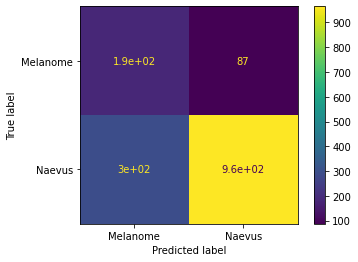

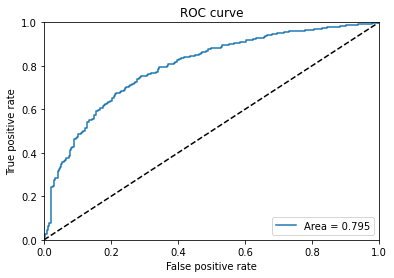

Cross_val_score (auc): 0.7965385683067376


In [ ]:
featuresNames = ('SPML_4_2')

parameters = {
    'C' : (0.01, 0.1, 1),
    'penalty' : ('l1', 'l2')
}
run_and_test(featuresNames, parameters, LinearSVC(class_weight={0:4.59, 1:1}), hasConfidence=True)

Loading features...
GridSeach...
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1997s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   14.5s finished


0.7823866561952723
LinearSVC(C=0.01, class_weight={0: 4.59, 1: 1}, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)
Best estimator...
              precision    recall  f1-score   support

    Mélanome       0.39      0.63      0.48       273
      Naevus       0.91      0.79      0.84      1260

    accuracy                           0.76      1533
   macro avg       0.65      0.71      0.66      1533
weighted avg       0.82      0.76      0.78      1533

ROC score on test set :  0.7880748880748881


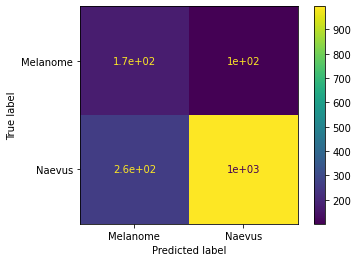

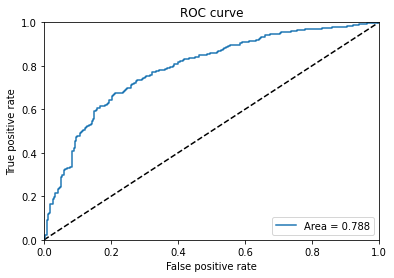

Cross_val_score (auc): 0.7823875672490882


In [ ]:
featuresNames = ('SPCO_4_2')

parameters = {
    'C' : (0.01, 0.1, 1),
    'penalty' : ('l1', 'l2')
}
run_and_test(featuresNames, parameters, LinearSVC(class_weight={0:4.59, 1:1}), hasConfidence=True)

Loading features...
GridSeach...
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0082s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0273s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0593s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.5s finished


0.7801674229306333
LinearSVC(C=1, class_weight={0: 5, 1: 1}, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)
Best estimator...
              precision    recall  f1-score   support

    Mélanome       0.35      0.66      0.45       273
      Naevus       0.91      0.73      0.81      1260

    accuracy                           0.72      1533
   macro avg       0.63      0.69      0.63      1533
weighted avg       0.81      0.72      0.75      1533

ROC score on test set :  0.7738356881214024


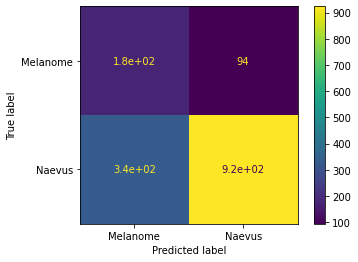

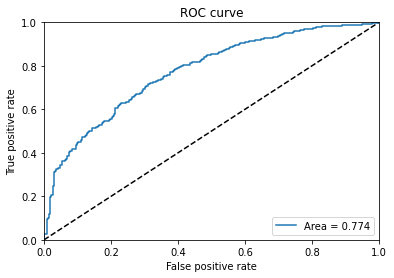

Cross_val_score (auc): 0.7801674229306333


In [ ]:
featuresNames = ('SP60_4')

parameters = {
    'C' : (0.01, 0.1, 1),
    'penalty' : ('l1', 'l2')
}
run_and_test(featuresNames, parameters, LinearSVC(class_weight={0:5, 1:1}), hasConfidence=True)

Loading features...
GridSeach...
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0095s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0393s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1380s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.7s finished


0.7752616413393338
LinearSVC(C=0.1, class_weight={0: 4, 1: 1}, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)
Best estimator...
              precision    recall  f1-score   support

    Mélanome       0.37      0.54      0.44       273
      Naevus       0.89      0.80      0.84      1260

    accuracy                           0.75      1533
   macro avg       0.63      0.67      0.64      1533
weighted avg       0.80      0.75      0.77      1533

ROC score on test set :  0.77572533286819


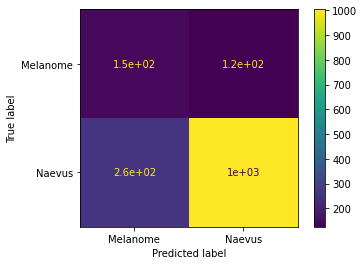

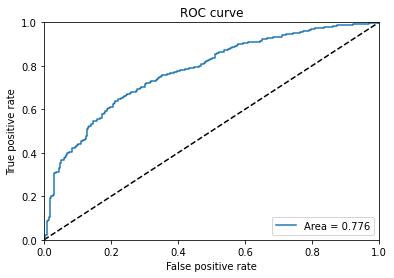

Cross_val_score (auc): 0.7752616413393338


In [ ]:
featuresNames = ('SP60_nomean_4')

parameters = {
    'C' : (0.01, 0.1, 1),
    'penalty' : ('l1', 'l2')
}
run_and_test(featuresNames, parameters, LinearSVC(class_weight={0:4, 1:1}), hasConfidence=True)

Loading features...
GridSeach...
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0118s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0434s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0772s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.8s finished


0.7668955147001999
LinearSVC(C=0.01, class_weight={0: 4.59, 1: 1}, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)
Best estimator...
              precision    recall  f1-score   support

    Mélanome       0.36      0.63      0.46       273
      Naevus       0.90      0.76      0.82      1260

    accuracy                           0.73      1533
   macro avg       0.63      0.69      0.64      1533
weighted avg       0.81      0.73      0.76      1533

ROC score on test set :  0.7764201407058551


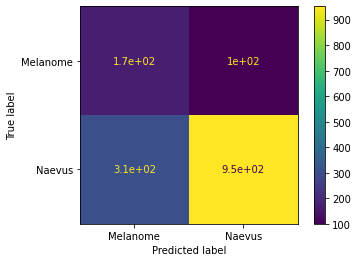

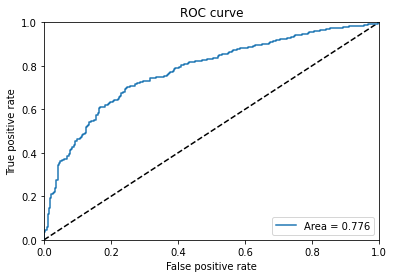

Cross_val_score (auc): 0.7668946003559676


In [ ]:
featuresNames = ('SPML_4_2_HSV')

parameters = {
    'C' : (0.01, 0.1, 1),
    'penalty' : ('l1', 'l2')
}
run_and_test(featuresNames, parameters, LinearSVC(class_weight={0:4.59, 1:1}), hasConfidence=True)

Loading features...
GridSeach...
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0082s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0505s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0911s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.1s finished


0.799172886613199
LinearSVC(C=1, class_weight={0: 4.59, 1: 1}, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)
Best estimator...
              precision    recall  f1-score   support

    Mélanome       0.39      0.64      0.49       273
      Naevus       0.91      0.78      0.84      1260

    accuracy                           0.76      1533
   macro avg       0.65      0.71      0.66      1533
weighted avg       0.82      0.76      0.78      1533

ROC score on test set :  0.7928019070876214


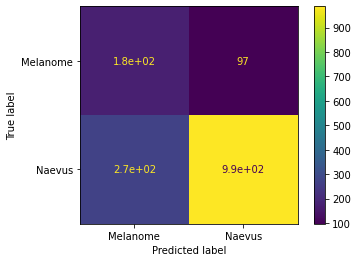

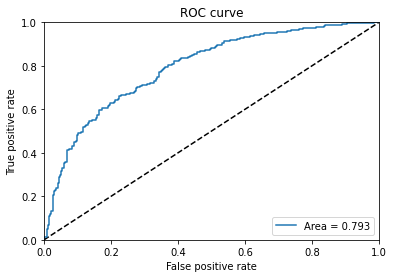

Cross_val_score (auc): 0.799172886613199


In [ ]:
featuresNames = ('SPML_4_2_cielab')

parameters = {
    'C' : (0.01, 0.1, 1),
    'penalty' : ('l1', 'l2')
}
run_and_test(featuresNames, parameters, LinearSVC(class_weight={0:4.59, 1:1}), hasConfidence=True)

Loading features...
GridSeach...
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1729s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1108s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.0s finished


0.7819343734629028
LinearSVC(C=1, class_weight={0: 4.59, 1: 1}, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)
Best estimator...
              precision    recall  f1-score   support

    Mélanome       0.39      0.63      0.48       273
      Naevus       0.91      0.78      0.84      1260

    accuracy                           0.76      1533
   macro avg       0.65      0.71      0.66      1533
weighted avg       0.82      0.76      0.78      1533

ROC score on test set :  0.7841880341880342


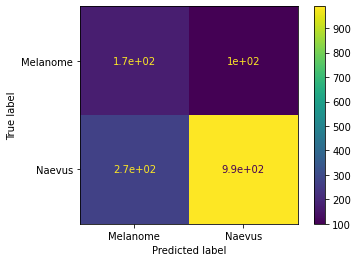

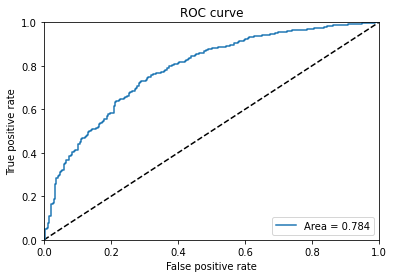

Cross_val_score (auc): 0.7819343734629028


In [ ]:
featuresNames = ('SPML_4_2_ycbcr')

parameters = {
    'C' : (0.01, 0.1, 1),
    'penalty' : ('l1', 'l2')
}
run_and_test(featuresNames, parameters, LinearSVC(class_weight={0:4.59, 1:1}), hasConfidence=True)

## Asymétrie de forme (aire par quadrant)

In [ ]:
def get_area_by_quadrant(quadrants, img):
  areas = []
  for quad_num in range(4):
    areas.append(len([pixel for row in quadrants for pixel in row if pixel == quad_num]))
  return areas


def f_area_quad(img, quadrants):
  areas = get_area_by_quadrant(quadrants, img)
  return scalar_feature_diff(areas)

### Save

In [ ]:
def get_features(img, mask):
  points = np.asarray(get_points(mask))
  center = get_center(points)
  axe1, axe2 = get_axes(points, method='PCA', mask=mask)
  quadrants = make_quadrants(mask, points, axe1, axe2)
  features = f_area_quad(img, quadrants)
  return features

path = '/content/drive/MyDrive/Stage_LIS/Features/'
name = 'area_quad'

X, y = load_all_data('TRAIN/', verbose=True, get_features=get_features)
np.savetxt(path+'X_train_'+name+'.txt', X)

X, y = load_all_data('TEST/', verbose=True, get_features=get_features)
np.savetxt(path+'X_test_'+name+'.txt', X)

1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0
31.0
32.0
33.0
34.0
35.0
36.0
37.0
38.0
39.0
40.0
41.0
42.0
43.0
44.0
45.0
46.0
47.0
48.0
49.0
50.0
51.0
52.0
53.0
54.0
55.0
56.0
57.0
58.0
59.0
60.0
61.0
62.0
63.0
64.0
65.0
66.0
67.0
68.0
69.0
70.0
71.0
72.0
73.0
74.0
75.0
76.0
77.0
78.0
79.0
80.0
81.0
82.0
83.0
84.0
85.0
86.0
87.0
88.0
89.0
90.0
91.0
92.0
93.0
94.0
95.0
96.0
97.0
98.0
99.0
100.0
0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0
31.0
32.0
33.0
34.0
35.0
36.0
37.0
38.0
39.0
40.0
41.0
42.0
43.0
44.0
45.0
46.0
47.0
48.0
49.0
50.0
51.0
52.0
53.0
54.0
55.0
56.0
57.0
58.0
59.0
60.0
61.0
62.0
63.0
64.0
65.0
66.0
67.0
68.0
69.0
70.0
71.0
72.0
73.0
74.0
75.0
76.0
77.0
78.0
79.0
80.0
81.0
82.0
83.0
84.0
85.0
86.0
87.0
88.0
89.0
90.0
91.0
92.0
93.0
94.0
95.0
96.0
97.0
98.0
99.0
100.0
1.0
2.0
3.0


### Results

Loading features...
GridSeach...
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.0s finished


0.7227942752773582
LinearSVC(C=0.01, class_weight={0: 4.59, 1: 1}, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)
Best estimator...
              precision    recall  f1-score   support

    Mélanome       0.34      0.59      0.43       273
      Naevus       0.89      0.75      0.82      1260

    accuracy                           0.72      1533
   macro avg       0.62      0.67      0.62      1533
weighted avg       0.79      0.72      0.75      1533

ROC score on test set :  0.7223239723239723


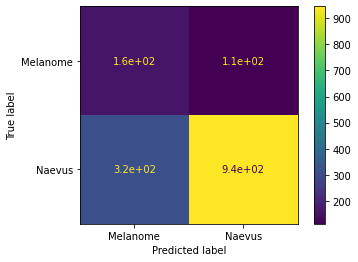

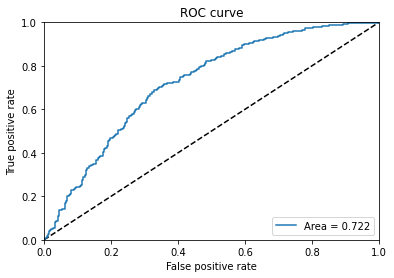

Cross_val_score (auc): 0.7227942752773582


In [ ]:
name = 'area_quad'
featuresNames = [name]

parameters = {
    'C' : (0.01, 0.1, 1),
    'penalty' : ('l1', 'l2')
}
run_and_test(featuresNames, parameters, LinearSVC(class_weight={0:4.59, 1:1}), hasConfidence=True)

# Loading data

In [ ]:
# color_models : bgr, hsv, cielab, ycrcb
def get_features(img, mask, color_models=('bgr')):
  features = []
  points = np.asarray(get_points(mask))
  center = get_center(points)
  axe1, axe2 = get_axes(points)
  quadrants = make_quadrants(mask, points, axe1, axe2)
  for mcolor in color_models:
    if mcolor == 'rgb':
      pass
    elif mcolor == 'hsv':
      img = cv.cvtColor(img, cv2.COLOR_BGR2HSV)
    elif mcolor == 'cielab':
      img = cv.cvtColor(img, cv2.COLOR_BGR2Lab)
    elif mcolor == 'ycbcr':
      img = cv.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    else:
      raise Exception('Correct values for color_models are : bgr, hsv, cielab, ycrcb')
    cropped = get_cropped(img, mask, points, axe1, axe2)
    images = cut_image(cropped)
    #features += f_color_mean(img, quadrants)
    #features += f_histo(img, quadrants)
    #features += f_distareas(img, quadrants, points)
    #features += list(f_entropy(cropped, quadrants))
    #features += f_superpixel_circles(img, center, quadrants)
    #features += f_lum_angles(img, quadrants, points)
    #features += f_superpixel_diff(images)
    #features = f_beta(img, mask)
    #features = f_beta_quad(images, mask)
  return features

def load_data(folder, n_img=100, verbose=True, get_features=get_features, mask_folder=None):
  if n_img == -1:
    n_img = sum(len(files) for _, _, files in os.walk('/content/ISIC_2019/NON_SEGMENTEES/'+folder))
  lastVerbose = 0
  path = base+'NON_SEGMENTEES/'+folder
  mask_path = base+'SEGMENTEES/MASK/'+folder
  if mask_folder != None:
    mask_path = base+'SEGMENTEES/MASK/'+mask_folder
  X = []
  y = []
  for lesion_type in ('MEL', 'NEV'):
    current_path = path+lesion_type+'/'
    current_mask_path = mask_path+lesion_type+'/'
    files = sorted([f for f in listdir(current_path) if isfile(join(current_path,f))])
    i = 0
    for file in files:
      percent = round(i/n_img*100*2)
      if i > n_img/2:
        break
      if verbose and lastVerbose != percent:
        print(percent)
        lastVerbose = percent
        #print(current_path+file)
      img = cv2.imread(current_path+file)
      mask = cv2.imread(current_mask_path+file[:-4]+'_Mask.jpg', 0)
      img = cv2.resize(img, img_shape)
      mask = cv2.resize(mask, img_shape)
      X.append(get_features(img, mask))
      y.append(int(lesion_type == 'NEV'))
      i += 1
  return X, y

def load_all_data(folder, verbose=True, get_features=get_features, mask_folder=None):
  lastVerbose = 0
  path = base+'NON_SEGMENTEES/'+folder
  mask_path = base+'SEGMENTEES/MASK/'+folder
  if mask_folder != None:
    mask_path = base+'SEGMENTEES/MASK/'+mask_folder
  X = []
  y = []
  for lesion_type in ('MEL', 'NEV'):
    current_path = path+lesion_type+'/'
    current_mask_path = mask_path+lesion_type+'/'
    files = sorted([f for f in listdir(current_path) if isfile(join(current_path,f))])
    n_img = len(files)
    i = 0
    for file in files:
      percent = round(i/n_img*100)
      if verbose and lastVerbose != percent:
        print(percent)
        lastVerbose = percent
        #print(current_path+file)
      img = cv2.imread(current_path+file)
      mask = cv2.imread(current_mask_path+file[:-4]+'_Mask.jpg', 0)
      img = cv2.resize(img, img_shape)
      mask = cv2.resize(mask, img_shape)
      X.append(get_features(img, mask))
      y.append(int(lesion_type == 'NEV'))
      i += 1
  return X, y

class DataLoader():
  def __init__(self, featuresNames, featuresPath='/content/drive/MyDrive/Stage_LIS/Features/', scaler=sklearn.preprocessing.MinMaxScaler):
    self.names = featuresNames
    self.path = featuresPath
    self.scaler = scaler

  def load(self, normalize=True, centering=False):
    featuresPath = self.path
    featuresNames = self.names
    scaler = self.scaler()
    X_trainL = []
    X_testL = []
    y_train = np.loadtxt(featuresPath+'y_train.txt')
    y_test = np.loadtxt(featuresPath+'y_test.txt')
    if type(featuresNames) != str:
      for feature in featuresNames:
        xtrain = np.loadtxt(featuresPath+'X_train_'+feature+'.txt')
        xtest = np.loadtxt(featuresPath+'X_test_'+feature+'.txt')
        if normalize:
          scaler.fit(xtrain)
          xtrain = scaler.transform(xtrain)
          xtest = scaler.transform(xtest)
        if centering:
          xtrain -= 0.5
          xtest -= 0.5
        X_trainL.append(xtrain)
        X_testL.append(xtest)
      X_train = np.concatenate([elt for elt in X_trainL], axis=1)
      X_test = np.concatenate([elt for elt in X_testL], axis=1)
    else:
      datas = np.loadtxt(featuresPath+'X_train_'+featuresNames+'.txt')
      scaler.fit(datas)
      X_train = scaler.transform(datas)
      X_test = scaler.transform(np.loadtxt(featuresPath+'X_test_'+featuresNames+'.txt'))
    return X_train, y_train, X_test, y_test

# Centrer les features en zéro

Loading features...
GridSeach...
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0201s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Batch computation too slow (2.1030s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0399s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Batch computation too slow (7.9330s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   22.9s finished


0.8480226546556388
LinearSVC(C=0.01, class_weight={0: 4.59, 1: 1}, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)
Best estimator...
              precision    recall  f1-score   support

    Mélanome       0.41      0.77      0.54       273
      Naevus       0.94      0.76      0.84      1260

    accuracy                           0.76      1533
   macro avg       0.67      0.77      0.69      1533
weighted avg       0.85      0.76      0.79      1533

ROC score on test set :  0.8444037444037443


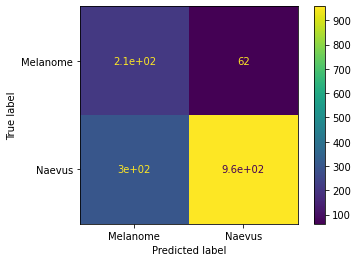

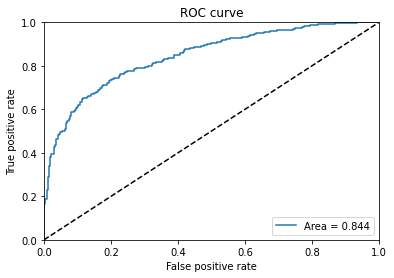

Cross_val_score (auc): 0.8480226546556388


In [ ]:
featuresNames = ['beta', 'beta_quad', 'M_ColorMean',
                'histos', 'SPML_4_2']

parameters = {
    'C' : (0.01, 0.1, 1),
    'penalty' : ('l1', 'l2')
}
run_and_test(featuresNames, parameters, LinearSVC(class_weight={0:4.59, 1:1}), hasConfidence=True, centering=True)

Loading features...
GridSeach...
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0166s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Batch computation too slow (2.3056s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:   12.6s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   16.2s finished


0.8500736211336276
LinearSVC(C=0.01, class_weight={0: 4.59, 1: 1}, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)
Best estimator...
              precision    recall  f1-score   support

    Mélanome       0.41      0.77      0.53       273
      Naevus       0.94      0.76      0.84      1260

    accuracy                           0.76      1533
   macro avg       0.67      0.76      0.69      1533
weighted avg       0.84      0.76      0.78      1533

ROC score on test set :  0.8476946334089192


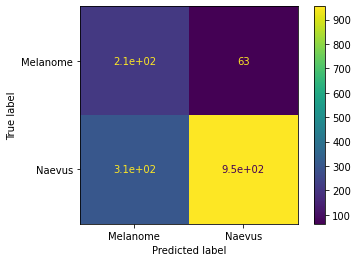

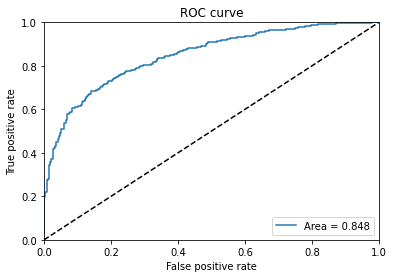

Cross_val_score (auc): 0.8500736211336276


In [ ]:
featuresNames = ['beta', 'beta_quad', 'M_ColorMean',
                'histos', 'SPML_4_2']

parameters = {
    'C' : (0.01, 0.1, 1),
    'penalty' : ('l1', 'l2')
}
run_and_test(featuresNames, parameters, LinearSVC(class_weight={0:4.59, 1:1}), hasConfidence=True, centering=False)

# Modèle final

In [ ]:
featuresNames = ['M_ColorMean', 'SPC_2_1', 'SPC_2_2', 'SPML_2_1', 'SPO', 'beta',
                 'beta_quad', 'color_mean', 'distareas', 'histos', 'new_SPC_2_1',
                 'new_color_mean', 'M_ColorMean', 'Minim_color_mean']

Loading features...
GridSeach...
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.2min finished
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.8228220318137073
LinearSVC(C=0.01, class_weight={0: 4.59, 1: 1}, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)
Best estimator...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

    Mélanome       0.41      0.73      0.53       273
      Naevus       0.93      0.77      0.84      1260

    accuracy                           0.77      1533
   macro avg       0.67      0.75      0.69      1533
weighted avg       0.84      0.77      0.79      1533

ROC score on test set :  0.8454939240653527


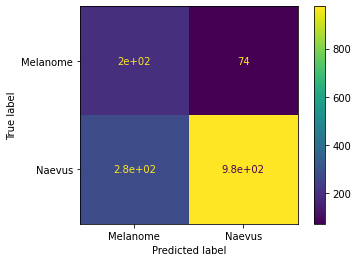

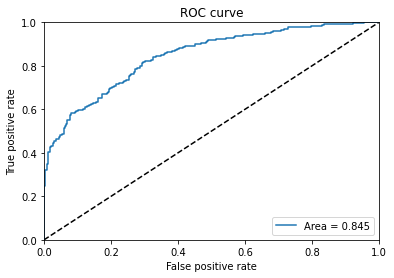

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Cross_val_score (auc): 0.8228475988486942


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [ ]:
parameters = {
    'C' : (0.01, 0.1, 1),
    'penalty' : ('l1', 'l2')
}
run_and_test(featuresNames, parameters, LinearSVC(class_weight={0:4.59, 1:1}), hasConfidence=True)

Loading features...
GridSeach...
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   35.0s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   55.6s finished


0.7682063315592215
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')
Best estimator...
              precision    recall  f1-score   support

    Mélanome       0.66      0.26      0.38       273
      Naevus       0.86      0.97      0.91      1260

    accuracy                           0.84      1533
   macro avg       0.76      0.62      0.64      1533
weighted avg       0.82      0.84      0.82      1533

ROC score on test set :  0.6171855921855922


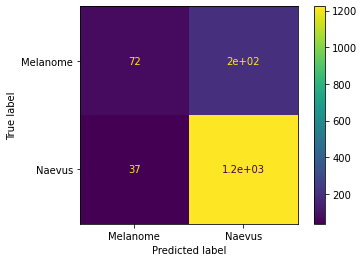

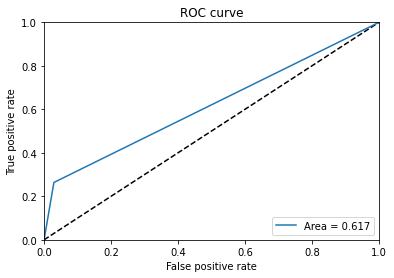

NameError: ignored

In [ ]:
parameters = {
    'n_neighbors' : (2,5,10)
}

clf = KNeighborsClassifier()

print('Loading features...')
loader = DataLoader(featuresNames)
X_train, y_train, X_test, y_test = loader.load()
print('GridSeach...')
gs = GridSearchCV(clf, parameters, scoring='roc_auc', n_jobs=-1, verbose=10).fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_estimator_)
clf = gs.best_estimator_

print('Best estimator...')
clf.fit(X_train, y_train)

predictions = clf.predict(X_test)
confidence = clf.predict_proba(X_test)
visu_results(y_test, predictions, confidence=confidence)

print('Cross_val_score (auc):',np.mean(cross_val_score(clf, X_train, y_train, scoring='roc_auc')))

1
              precision    recall  f1-score   support

    Mélanome       0.66      0.26      0.38       273
      Naevus       0.86      0.97      0.91      1260

    accuracy                           0.84      1533
   macro avg       0.76      0.62      0.64      1533
weighted avg       0.82      0.84      0.82      1533

ROC score on test set :  0.7908613872899587


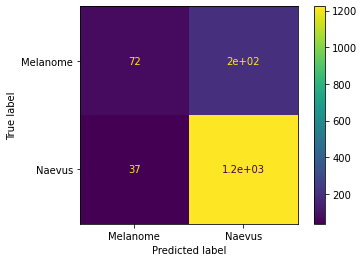

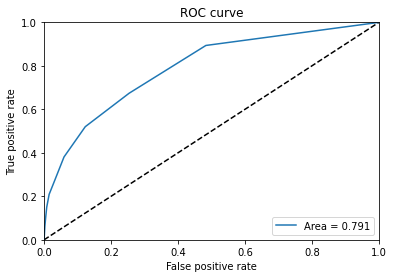

In [ ]:
def visu_results(y_test, predictions, normalize=None, confidence=None):
  y_test = np.asarray(y_test)
  if len(y_test.shape) == 1:
    y_testOH = keras.utils.to_categorical(y_test)
  if len(predictions.shape) == 1:
    predictions = keras.utils.to_categorical(predictions)
  print(len(y_test.shape))
  cm = confusion_matrix(np.argmax(y_testOH, axis=1), np.argmax(predictions, axis=1), normalize=normalize)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                    display_labels=('Melanome', 'Naevus'))
  disp.plot()
  print(classification_report(np.argmax(y_testOH, axis=1),
                            np.argmax(predictions, axis=1),
                            target_names=('Mélanome', 'Naevus')))
  if confidence is None:
    print('ROC score on test set : ',roc_auc_score(y_testOH, predictions))
    fpr, tpr, thresh = roc_curve(np.asarray(y_testOH)[:,0], np.asarray(predictions)[:,0])
  else:
    print('ROC score on test set : ',roc_auc_score(y_testOH, confidence))
    fpr, tpr, thresh = roc_curve(np.asarray(y_testOH)[:,0], np.asarray(confidence)[:,0])
  auc_keras = auc(fpr, tpr)
  plt.show()
  plt.figure(1)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr, tpr, label='Area = {:.3f}'.format(auc_keras))
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')
  plt.legend(loc='lower right')
  plt.xlim([0,1])
  plt.ylim([0,1])
  plt.show()


visu_results(y_test, predictions, confidence=confidence)

Loading features...
GridSeach...
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   35.6s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   56.4s finished


0.7682063315592215
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')
Best estimator...
1
              precision    recall  f1-score   support

    Mélanome       0.66      0.26      0.38       273
      Naevus       0.86      0.97      0.91      1260

    accuracy                           0.84      1533
   macro avg       0.76      0.62      0.64      1533
weighted avg       0.82      0.84      0.82      1533



ValueError: ignored

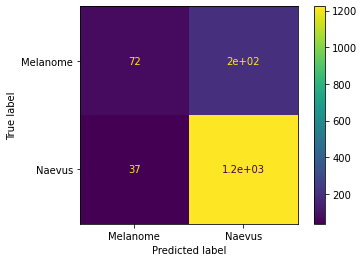

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

parameters = {
    'n_neighbors' : (2,5,10)
}

clf = KNeighborsClassifier()

print('Loading features...')
loader = DataLoader(featuresNames)
X_train, y_train, X_test, y_test = loader.load()
print('GridSeach...')
gs = GridSearchCV(clf, parameters, scoring='roc_auc', n_jobs=-1, verbose=10).fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_estimator_)
clf = gs.best_estimator_

print('Best estimator...')
clf.fit(X_train, y_train)

predictions = clf.predict(X_test)
confidence = clf.predict_proba(X_test)
visu_results(y_test, predictions, confidence=confidence)

print('Cross_val_score (auc):',np.mean(cross_val_score(clf, X_train, y_train, scoring='roc_auc')))

Loading features...
GridSeach...
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   41.6s finished


0.862325349018396
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight={0: 4, 1: 1},
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Best estimator...
              precision    recall  f1-score   support

    Mélanome       0.77      0.30      0.43       273
      Naevus       0.87      0.98      0.92      1260

    accuracy                           0.86      1533
   macro avg       0.82      0.64      0.67      1533
weighted avg       0.85      0.86      0.83      1533

ROC score on test set :  0.6388278388278388


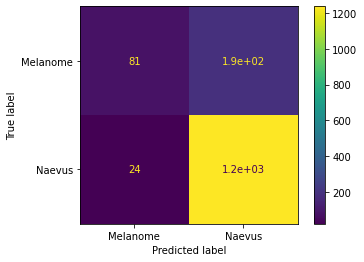

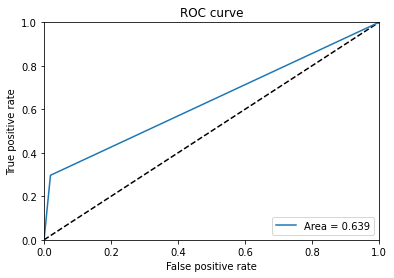

Cross_val_score (auc): 0.8627876367240557


In [ ]:
from sklearn.ensemble import RandomForestClassifier

parameters = {
    'n_estimators' : (50,100)
}

clf = RandomForestClassifier(class_weight={0:4,1:1})

print('Loading features...')
loader = DataLoader(featuresNames)
X_train, y_train, X_test, y_test = loader.load()
print('GridSeach...')
gs = GridSearchCV(clf, parameters, scoring='roc_auc', n_jobs=-1, verbose=10).fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_estimator_)
clf = gs.best_estimator_

print('Best estimator...')
clf.fit(X_train, y_train)

predictions = clf.predict(X_test)
visu_results(y_test, predictions)

print('Cross_val_score (auc):',np.mean(cross_val_score(clf, X_train, y_train, scoring='roc_auc')))

Loading features...
GridSeach...
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.8min finished


0.8240622098517095
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)
Best estimator...
              precision    recall  f1-score   support

    Mélanome       0.61      0.50      0.55       273
      Naevus       0.90      0.93      0.91      1260

    accuracy                           0.85      1533
   macro avg       0.75      0.71      0.73      1533
weighted avg       0.85      0.85      0.85      1533

ROC score on test set :  0.714957264957265


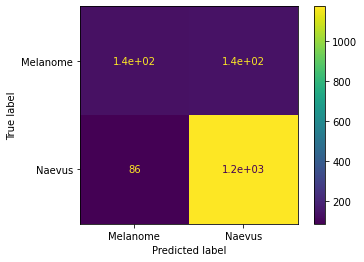

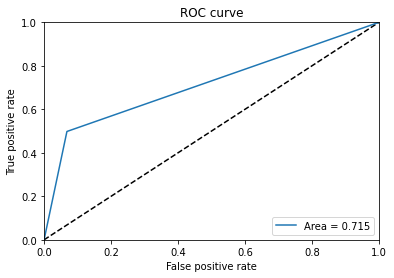

Cross_val_score (auc): 0.8240622098517095


In [ ]:
from sklearn.ensemble import AdaBoostClassifier

parameters = {
    'n_estimators' : (50,100)
}

clf = AdaBoostClassifier()

print('Loading features...')
loader = DataLoader(featuresNames)
X_train, y_train, X_test, y_test = loader.load()
print('GridSeach...')
gs = GridSearchCV(clf, parameters, scoring='roc_auc', n_jobs=-1, verbose=10).fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_estimator_)
clf = gs.best_estimator_

print('Best estimator...')
clf.fit(X_train, y_train)

predictions = clf.predict(X_test)
visu_results(y_test, predictions)

print('Cross_val_score (auc):',np.mean(cross_val_score(clf, X_train, y_train, scoring='roc_auc')))

Loading features...
GridSeach...
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  2.3min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.0min finished


0.8197217745639909
SVC(C=1.0, break_ties=False, cache_size=200, class_weight={0: 4, 1: 1},
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='rbf', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
Best estimator...
1
              precision    recall  f1-score   support

    Mélanome       0.48      0.67      0.56       273
      Naevus       0.92      0.85      0.88      1260

    accuracy                           0.81      1533
   macro avg       0.70      0.76      0.72      1533
weighted avg       0.84      0.81      0.83      1533

ROC score on test set :  0.8548287691144834


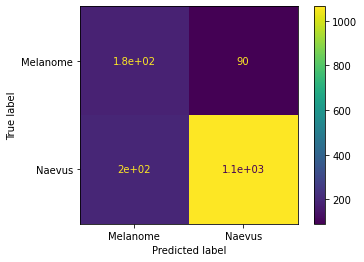

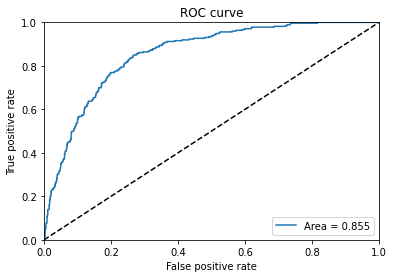

Cross_val_score (auc): 0.8197217745639909


In [ ]:
from sklearn.ensemble import AdaBoostClassifier

parameters = {
}

clf = SVC(class_weight={0:4,1:1}, probability=True)

print('Loading features...')
loader = DataLoader(featuresNames)
X_train, y_train, X_test, y_test = loader.load()
print('GridSeach...')
gs = GridSearchCV(clf, parameters, scoring='roc_auc', n_jobs=-1, verbose=10).fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_estimator_)
clf = gs.best_estimator_

print('Best estimator...')
clf.fit(X_train, y_train)

predictions = clf.predict(X_test)
confidence = clf.predict_proba(X_test)

visu_results(y_test, predictions, confidence=confidence)

print('Cross_val_score (auc):',np.mean(cross_val_score(clf, X_train, y_train, scoring='roc_auc')))

Loading features...
GridSeach...
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   34.4s remaining:   23.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   48.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   48.6s finished


0.8043444275457323
SVC(C=1.0, break_ties=False, cache_size=200, class_weight={0: 4, 1: 1},
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='poly', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
Best estimator...
              precision    recall  f1-score   support

    Mélanome       0.61      0.39      0.48       273
      Naevus       0.88      0.95      0.91      1260

    accuracy                           0.85      1533
   macro avg       0.74      0.67      0.69      1533
weighted avg       0.83      0.85      0.83      1533

ROC score on test set :  0.6675518925518925


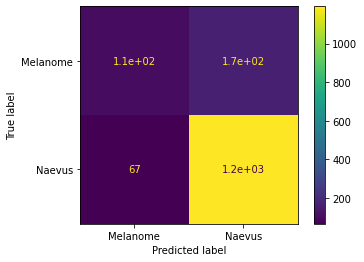

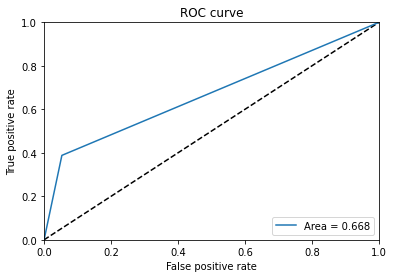

Cross_val_score (auc): 0.8043444275457323


In [ ]:
from sklearn.ensemble import AdaBoostClassifier

parameters = {
}

clf = SVC(class_weight={0:4,1:1}, kernel='poly')

print('Loading features...')
loader = DataLoader(featuresNames)
X_train, y_train, X_test, y_test = loader.load()
print('GridSeach...')
gs = GridSearchCV(clf, parameters, scoring='roc_auc', n_jobs=-1, verbose=10).fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_estimator_)
clf = gs.best_estimator_

print('Best estimator...')
clf.fit(X_train, y_train)

predictions = clf.predict(X_test)
visu_results(y_test, predictions)

print('Cross_val_score (auc):',np.mean(cross_val_score(clf, X_train, y_train, scoring='roc_auc')))

Loading features...
GridSeach...
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  7.4min remaining:  5.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  8.9min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  8.9min finished


0.7974560370184751
SVC(C=1.0, break_ties=False, cache_size=200, class_weight={0: 4, 1: 1},
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
Best estimator...
              precision    recall  f1-score   support

    Mélanome       0.41      0.71      0.52       273
      Naevus       0.92      0.78      0.85      1260

    accuracy                           0.77      1533
   macro avg       0.67      0.74      0.68      1533
weighted avg       0.83      0.77      0.79      1533

ROC score on test set :  0.7427655677655678


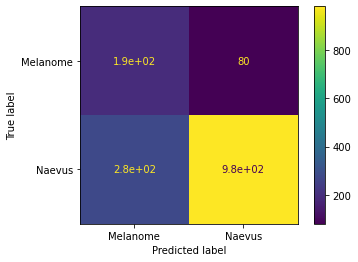

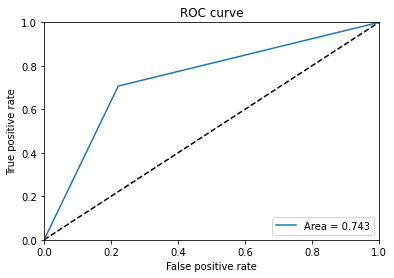

Cross_val_score (auc): 0.7974560370184751


In [ ]:
from sklearn.ensemble import AdaBoostClassifier

parameters = {
}

clf = SVC(class_weight={0:4,1:1}, kernel='linear')

print('Loading features...')
loader = DataLoader(featuresNames)
X_train, y_train, X_test, y_test = loader.load()
print('GridSeach...')
gs = GridSearchCV(clf, parameters, scoring='roc_auc', n_jobs=-1, verbose=10).fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_estimator_)
clf = gs.best_estimator_

print('Best estimator...')
clf.fit(X_train, y_train)

predictions = clf.predict(X_test)
visu_results(y_test, predictions)

print('Cross_val_score (auc):',np.mean(cross_val_score(clf, X_train, y_train, scoring='roc_auc')))

Loading features...
GridSeach...
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   34.3s remaining:   22.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   47.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   47.9s finished


0.8089839248535995
SVC(C=1.0, break_ties=False, cache_size=200, class_weight={0: 6, 1: 1},
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
Best estimator...
              precision    recall  f1-score   support

    Mélanome       0.44      0.73      0.55       273
      Naevus       0.93      0.80      0.86      1260

    accuracy                           0.79      1533
   macro avg       0.69      0.76      0.71      1533
weighted avg       0.84      0.79      0.81      1533

ROC score on test set :  0.7644688644688646


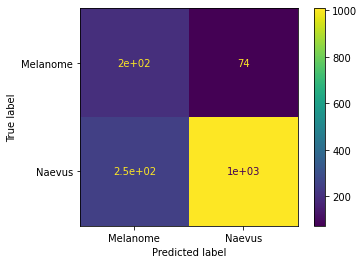

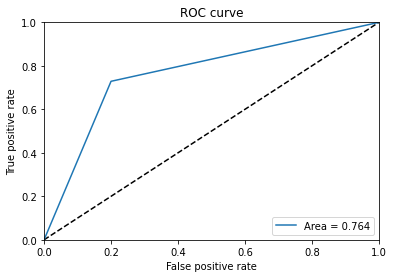

Cross_val_score (auc): 0.8089839248535995


In [ ]:
from sklearn.ensemble import AdaBoostClassifier

parameters = {
}

clf = SVC(class_weight={0:6,1:1})

print('Loading features...')
loader = DataLoader(featuresNames)
X_train, y_train, X_test, y_test = loader.load()
print('GridSeach...')
gs = GridSearchCV(clf, parameters, scoring='roc_auc', n_jobs=-1, verbose=10).fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_estimator_)
clf = gs.best_estimator_

print('Best estimator...')
clf.fit(X_train, y_train)

predictions = clf.predict(X_test)
visu_results(y_test, predictions)

print('Cross_val_score (auc):',np.mean(cross_val_score(clf, X_train, y_train, scoring='roc_auc')))

# Gradient boosting

In [ ]:
from xgboost import XGBClassifier
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder

def get_features():
  ohe = OneHotEncoder()

  featuresNames = ['beta_quad_RGB', 'beta_quad_HSV', 'beta_quad_Lab', 'beta_quad_YCrCb',
                  'histos', 'histos_HSV', 'histos_Lab', 'histos_YCrCb',
                  'SPML_4_2', 'SPML_4_2_HSV', 'SPML_4_2_cielab', 'SPML_4_2_ycbcr',
                  'SPO', 'SP60_4']

  loader = DataLoader(featuresNames)
  X_train, y_train, X_test, y_test = loader.load(centering=True)

  ohe.fit(y_train.reshape((-1, 1)))
  y_trainOH = ohe.transform(y_train.reshape((-1, 1))).toarray()
  y_testOH = ohe.transform(y_test.reshape((-1, 1))).toarray()
  return X_train, y_trainOH, X_test, y_testOH

X_train, y_train, X_test, y_test = get_features()
#X_train, y_train = shuffle(X_train, y_train)

y_train = np.argmax(y_train, axis=1)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3)

sample_weight = [4.59 if i == 0 else 1 for i in y_train]

clf = XGBClassifier(n_estimators=1000, learning_rate=0.01)

clf.fit(X_train, y_train, 
             early_stopping_rounds=10,
             eval_set=[(X_valid, y_valid)],
             verbose=False, eval_metric='auc', sample_weight=sample_weight)

predictions = clf.predict_proba(X_test)

#print('Cross_val_score (auc):',np.mean(cross_val_score(clf, X_train, y_train, scoring='roc_auc')))

#run_and_test(featuresNames, parameters, LinearSVC(class_weight={0:4.59, 1:1}), hasConfidence=True)

              precision    recall  f1-score   support

    Mélanome       0.39      0.89      0.54       273
      Naevus       0.97      0.70      0.81      1260

    accuracy                           0.73      1533
   macro avg       0.68      0.79      0.67      1533
weighted avg       0.86      0.73      0.76      1533

ROC score on test set :  0.8751787894645038


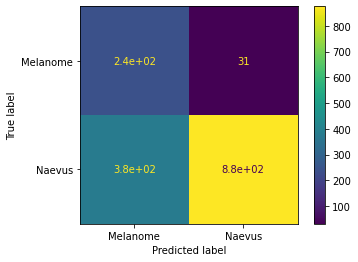

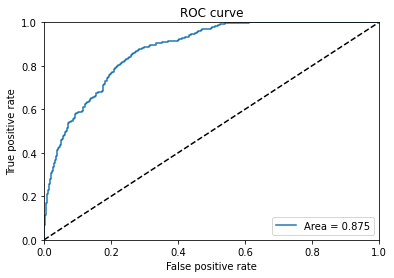

In [ ]:
visu_results(y_test, predictions)

In [ ]:
!pip install shap

     |████████████████████████████████| 358kB 7.8MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491626 sha256=410ff3a570bc0f7295e3383130d0a403db7bc45bd5609e6c7b7219fbee6c13d0
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


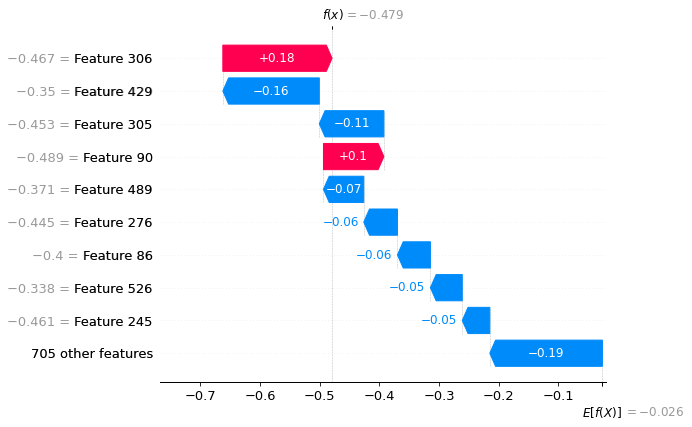

In [ ]:
import shap

explainer = shap.Explainer(clf)
shap_values = explainer(X_test)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

In [ ]:
import pandas as pd

index2name = []
for i in range(36):
  index2name.append('beta_quad_RGB '+str(i))
for i in range(36):
  index2name.append('beta_quad_HSV '+str(i))
for i in range(36):
  index2name.append('beta_quad_Lab '+str(i))
for i in range(36):
  index2name.append('beta_quad_YCrCb '+str(i))
for i in range(90):
  index2name.append('histos_RGB '+str(i))
for i in range(90):
  index2name.append('histos_HSV '+str(i))
for i in range(90):
  index2name.append('histos_Lab '+str(i))
for i in range(90):
  index2name.append('histos_YCrCb '+str(i))
for i in range(12):
  index2name.append('SPML_4_2_RGB '+str(i))
for i in range(12):
  index2name.append('SPML_4_2_HSV '+str(i))
for i in range(12):
  index2name.append('SPML_4_2_Lab '+str(i))
for i in range(12):
  index2name.append('SPML_4_2_YCrCb '+str(i))
for i in range(150):
  index2name.append('SPO '+str(i))
for i in range(12):
  index2name.append('SP60_4 '+str(i))

X_testlabel = pd.DataFrame(data=X_test, columns=index2name)

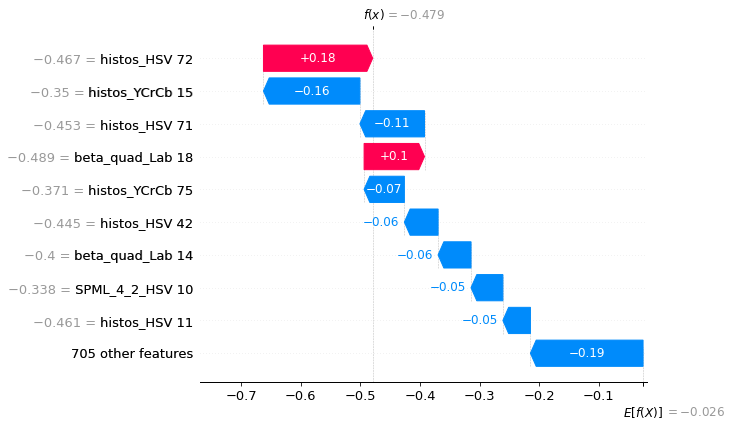

In [ ]:
import shap

explainer = shap.Explainer(clf)
shap_values = explainer(X_testlabel)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

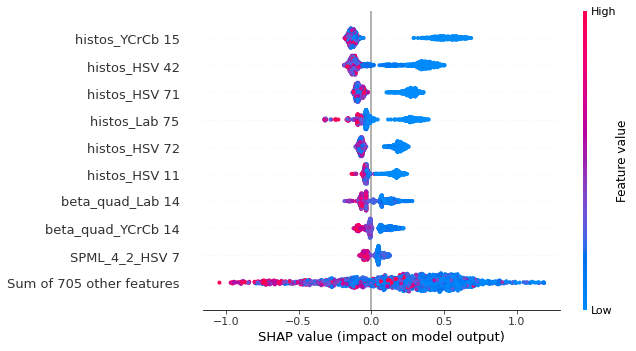

In [ ]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values)

In [ ]:
from xgboost import XGBClassifier
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder

def get_features():
  ohe = OneHotEncoder()

  featuresNames = ['beta_quad_RGB', 'beta_quad_HSV', 'beta_quad_Lab', 'beta_quad_YCrCb',
                  'histos', 'histos_HSV', 'histos_Lab', 'histos_YCrCb',
                  'SPML_4_2', 'SPML_4_2_HSV', 'SPML_4_2_cielab', 'SPML_4_2_ycbcr',
                  'SPO', 'SP60_4', 'beta']

  loader = DataLoader(featuresNames)
  X_train, y_train, X_test, y_test = loader.load(centering=True)

  ohe.fit(y_train.reshape((-1, 1)))
  y_trainOH = ohe.transform(y_train.reshape((-1, 1))).toarray()
  y_testOH = ohe.transform(y_test.reshape((-1, 1))).toarray()
  return X_train, y_trainOH, X_test, y_testOH

X_train, y_train, X_test, y_test = get_features()
#X_train, y_train = shuffle(X_train, y_train)

y_train = np.argmax(y_train, axis=1)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3)

sample_weight = [4.59 if i == 0 else 1 for i in y_train]

clf = XGBClassifier(n_estimators=1000, learning_rate=0.01)

clf.fit(X_train, y_train, 
             early_stopping_rounds=10,
             eval_set=[(X_valid, y_valid)],
             verbose=False, eval_metric='auc', sample_weight=sample_weight)

predictions = clf.predict_proba(X_test)

#print('Cross_val_score (auc):',np.mean(cross_val_score(clf, X_train, y_train, scoring='roc_auc')))

#run_and_test(featuresNames, parameters, LinearSVC(class_weight={0:4.59, 1:1}), hasConfidence=True)

In [ ]:
index2name = []
for i in range(36):
  index2name.append('beta_quad_RGB '+str(i))
for i in range(36):
  index2name.append('beta_quad_HSV '+str(i))
for i in range(36):
  index2name.append('beta_quad_Lab '+str(i))
for i in range(36):
  index2name.append('beta_quad_YCrCb '+str(i))
for i in range(90):
  index2name.append('histos_RGB '+str(i))
for i in range(90):
  index2name.append('histos_HSV '+str(i))
for i in range(90):
  index2name.append('histos_Lab '+str(i))
for i in range(90):
  index2name.append('histos_YCrCb '+str(i))
for i in range(12):
  index2name.append('SPML_4_2_RGB '+str(i))
for i in range(12):
  index2name.append('SPML_4_2_HSV '+str(i))
for i in range(12):
  index2name.append('SPML_4_2_Lab '+str(i))
for i in range(12):
  index2name.append('SPML_4_2_YCrCb '+str(i))
for i in range(150):
  index2name.append('SPO '+str(i))
for i in range(12):
  index2name.append('SP60_4 '+str(i))
for i in range(15):
  index2name.append('beta '+str(i))

X_testlabel = pd.DataFrame(data=X_test, columns=index2name)

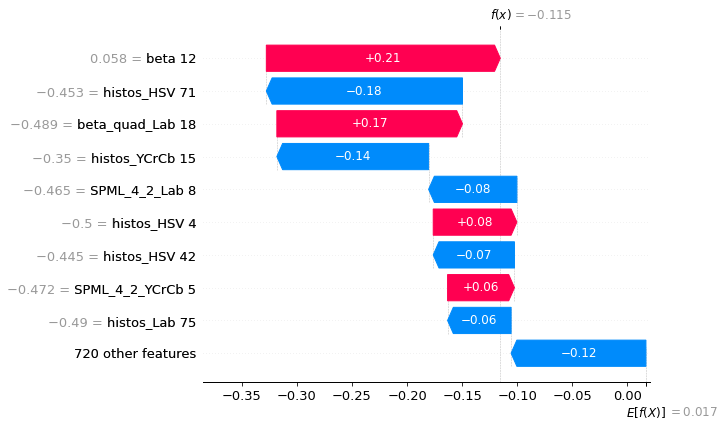

In [ ]:
explainer = shap.Explainer(clf)
shap_values = explainer(X_testlabel)
shap.plots.waterfall(shap_values[0])

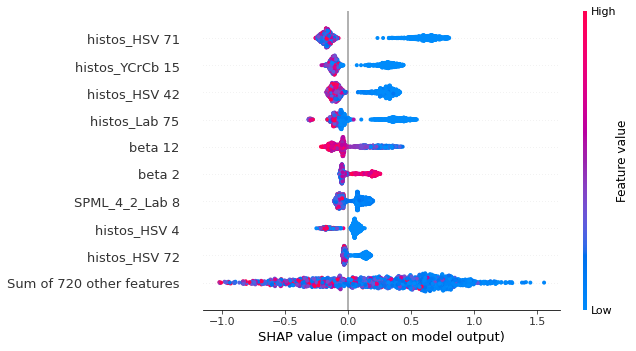

In [ ]:
shap.plots.beeswarm(shap_values)

              precision    recall  f1-score   support

    Mélanome       0.41      0.78      0.54       273
      Naevus       0.94      0.75      0.84      1260

    accuracy                           0.76      1533
   macro avg       0.67      0.77      0.69      1533
weighted avg       0.85      0.76      0.78      1533

ROC score on test set :  0.8463311820454678


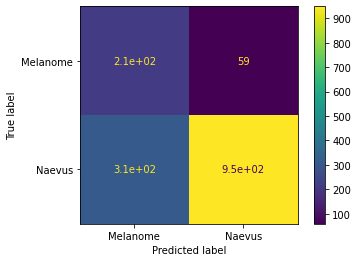

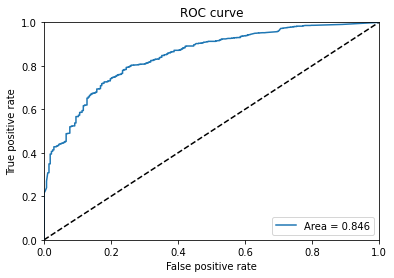

In [ ]:
from xgboost import XGBClassifier
from sklearn.utils import shuffle

featuresNames = ['beta', 'beta_quad',
                'histos', 'SPML_4_2']

loader = DataLoader(featuresNames)
X_train, y_train, X_test, y_test = loader.load(centering=False)

X_train, y_train = shuffle(X_train, y_train)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3)

sample_weight = [4 if i == 0 else 1 for i in y_train]

clf = XGBClassifier(n_estimators=1000, learning_rate=0.01)

clf.fit(X_train, y_train, 
             early_stopping_rounds=10,
             eval_set=[(X_valid, y_valid)],
             verbose=False, eval_metric='auc', sample_weight=sample_weight)

predictions = clf.predict_proba(X_test)
visu_results(y_test, predictions, confidence=predictions[:,1])

#print('Cross_val_score (auc):',np.mean(cross_val_score(clf, X_train, y_train, scoring='roc_auc')))

#run_and_test(featuresNames, parameters, LinearSVC(class_weight={0:4.59, 1:1}), hasConfidence=True)

In [ ]:
print('Cross_val_score (auc):',np.mean(cross_val_score(clf, X_train, y_train, scoring='roc_auc')))

Cross_val_score (auc): 0.86411211068197


              precision    recall  f1-score   support

    Mélanome       0.42      0.82      0.55       273
      Naevus       0.95      0.75      0.84      1260

    accuracy                           0.76      1533
   macro avg       0.68      0.79      0.70      1533
weighted avg       0.86      0.76      0.79      1533

ROC score on test set :  0.8706407349264492


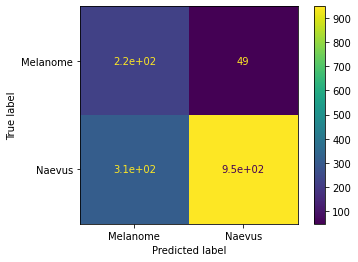

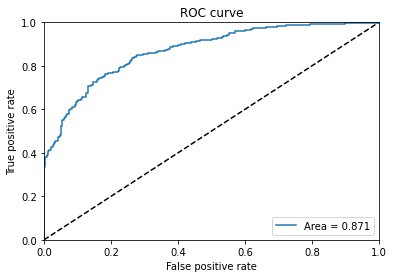

In [ ]:
from xgboost import XGBClassifier
from sklearn.utils import shuffle

featuresNames = ['beta', 'beta_quad', 'M_ColorMean',
                'histos', 'SPML_4_2']

loader = DataLoader(featuresNames)
X_train, y_train, X_test, y_test = loader.load(centering=False)

X_train, y_train = shuffle(X_train, y_train)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3)

sample_weight = [4.59 if i == 0 else 1 for i in y_train]

clf = XGBClassifier(n_estimators=1000, learning_rate=0.01)

clf.fit(X_train, y_train, 
             early_stopping_rounds=10,
             eval_set=[(X_valid, y_valid)],
             verbose=False, eval_metric='auc', sample_weight=sample_weight)

predictions = clf.predict_proba(X_test)
visu_results(y_test, predictions, confidence=predictions[:,1])

#print('Cross_val_score (auc):',np.mean(cross_val_score(clf, X_train, y_train, scoring='roc_auc')))

#run_and_test(featuresNames, parameters, LinearSVC(class_weight={0:4.59, 1:1}), hasConfidence=True)

              precision    recall  f1-score   support

    Mélanome       0.39      0.82      0.53       273
      Naevus       0.95      0.72      0.82      1260

    accuracy                           0.74      1533
   macro avg       0.67      0.77      0.68      1533
weighted avg       0.85      0.74      0.77      1533

ROC score on test set :  0.8604104889819175


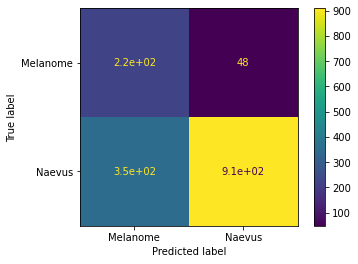

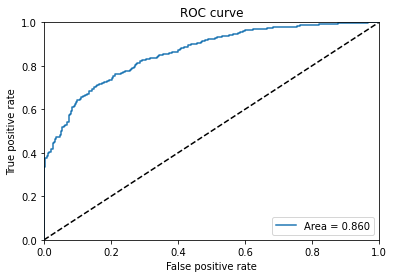

In [ ]:
from xgboost import XGBClassifier
from sklearn.utils import shuffle

featuresNames = ['beta', 'beta_quad', 'M_ColorMean',
                'histos', 'SPML_4_2']

loader = DataLoader(featuresNames)
X_train, y_train, X_test, y_test = loader.load(centering=False)

X_train, y_train = shuffle(X_train, y_train)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3)

sample_weight = [5 if i == 0 else 1 for i in y_train]

clf = XGBClassifier(n_estimators=1000, learning_rate=0.01)

clf.fit(X_train, y_train, 
             early_stopping_rounds=10,
             eval_set=[(X_valid, y_valid)],
             verbose=False, eval_metric='auc', sample_weight=sample_weight)

predictions = clf.predict_proba(X_test)
visu_results(y_test, predictions, confidence=predictions[:,1])

#print('Cross_val_score (auc):',np.mean(cross_val_score(clf, X_train, y_train, scoring='roc_auc')))

#run_and_test(featuresNames, parameters, LinearSVC(class_weight={0:4.59, 1:1}), hasConfidence=True)

              precision    recall  f1-score   support

    Mélanome       0.39      0.85      0.54       273
      Naevus       0.96      0.71      0.82      1260

    accuracy                           0.74      1533
   macro avg       0.67      0.78      0.68      1533
weighted avg       0.86      0.74      0.77      1533

ROC score on test set :  0.8643874643874645


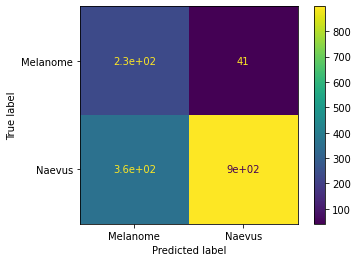

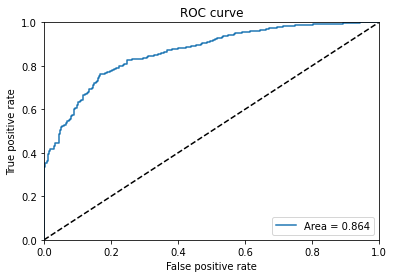

In [ ]:
from xgboost import XGBClassifier
from sklearn.utils import shuffle

featuresNames = ['beta', 'beta_quad', 'M_ColorMean',
                'histos', 'SPML_4_2']

loader = DataLoader(featuresNames)
X_train, y_train, X_test, y_test = loader.load(centering=False)

X_train, y_train = shuffle(X_train, y_train)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3)

sample_weight = [6 if i == 0 else 1 for i in y_train]

clf = XGBClassifier(n_estimators=1000, learning_rate=0.01)

clf.fit(X_train, y_train, 
             early_stopping_rounds=10,
             eval_set=[(X_valid, y_valid)],
             verbose=False, eval_metric='auc', sample_weight=sample_weight)

predictions = clf.predict_proba(X_test)
visu_results(y_test, predictions, confidence=predictions[:,1])

#print('Cross_val_score (auc):',np.mean(cross_val_score(clf, X_train, y_train, scoring='roc_auc')))

#run_and_test(featuresNames, parameters, LinearSVC(class_weight={0:4.59, 1:1}), hasConfidence=True)

              precision    recall  f1-score   support

    Mélanome       0.42      0.82      0.56       273
      Naevus       0.95      0.76      0.84      1260

    accuracy                           0.77      1533
   macro avg       0.69      0.79      0.70      1533
weighted avg       0.86      0.77      0.79      1533

ROC score on test set :  0.8681522181522181


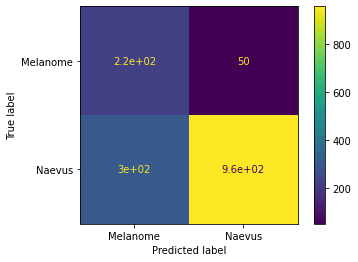

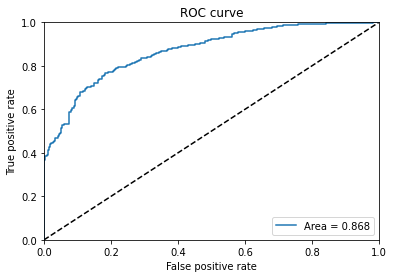

In [ ]:
from xgboost import XGBClassifier
from sklearn.utils import shuffle

featuresNames = ['beta', 'beta_quad', 'M_ColorMean',
                'histos', 'SPML_4_2']

loader = DataLoader(featuresNames)
X_train, y_train, X_test, y_test = loader.load(centering=True)

X_train, y_train = shuffle(X_train, y_train)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3)

sample_weight = [4.59 if i == 0 else 1 for i in y_train]

clf = XGBClassifier(n_estimators=1000, learning_rate=0.01)

clf.fit(X_train, y_train, 
             early_stopping_rounds=10,
             eval_set=[(X_valid, y_valid)],
             verbose=False, eval_metric='auc', sample_weight=sample_weight)

predictions = clf.predict_proba(X_test)
visu_results(y_test, predictions, confidence=predictions[:,1])

#print('Cross_val_score (auc):',np.mean(cross_val_score(clf, X_train, y_train, scoring='roc_auc')))

#run_and_test(featuresNames, parameters, LinearSVC(class_weight={0:4.59, 1:1}), hasConfidence=True)

              precision    recall  f1-score   support

    Mélanome       0.38      0.88      0.53       273
      Naevus       0.96      0.69      0.80      1260

    accuracy                           0.72      1533
   macro avg       0.67      0.79      0.67      1533
weighted avg       0.86      0.72      0.76      1533

ROC score on test set :  0.8760843653700797


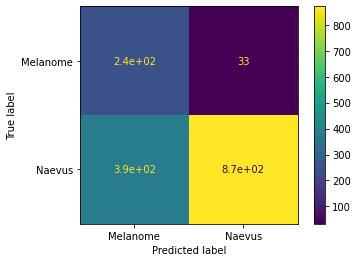

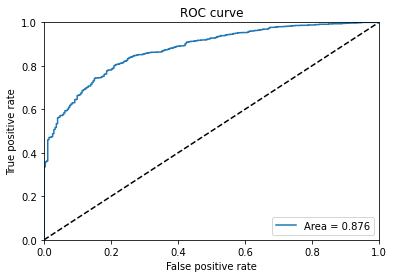

In [ ]:
from xgboost import XGBClassifier
from sklearn.utils import shuffle

featuresNames = ['beta', 'beta_quad', 'M_ColorMean',
                'histos', 'SPML_4_2', 'histos_HSV', 'histos_Lab', 'histos_YCrCb', 'SPO']

loader = DataLoader(featuresNames)
X_train, y_train, X_test, y_test = loader.load(centering=True)

X_train, y_train = shuffle(X_train, y_train)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3)

sample_weight = [4.59 if i == 0 else 1 for i in y_train]

clf = XGBClassifier(n_estimators=1000, learning_rate=0.01)

clf.fit(X_train, y_train, 
             early_stopping_rounds=10,
             eval_set=[(X_valid, y_valid)],
             verbose=False, eval_metric='auc', sample_weight=sample_weight)

predictions = clf.predict_proba(X_test)
visu_results(y_test, predictions, confidence=predictions[:,1])

#print('Cross_val_score (auc):',np.mean(cross_val_score(clf, X_train, y_train, scoring='roc_auc')))

#run_and_test(featuresNames, parameters, LinearSVC(class_weight={0:4.59, 1:1}), hasConfidence=True)

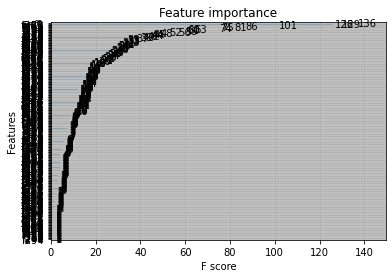

In [ ]:
from xgboost import plot_importance

plot_importance(clf)
plt.show()

Taille des features :
beta = 15
beta_quad = 120
color_mean = 9
histos = 90
SPML 4 2 = 12
SPO = 150 (50x3x2)

In [ ]:
index2name = []
for i in range(15):
  index2name.append('beta '+str(i))
for i in range(120):
  index2name.append('beta_quad '+str(i))
for i in range(9):
  index2name.append('M_ColorMean '+str(i))
for i in range(90):
  index2name.append('histos '+str(i))
for i in range(12):
  index2name.append('SPML_4_2 '+str(i))
for i in range(90):
  index2name.append('histos_HSV '+str(i))
for i in range(90):
  index2name.append('histos_Lab '+str(i))
for i in range(90):
  index2name.append('histos_YCrCb '+str(i))
for i in range(150):
  index2name.append('SPO '+str(i))

In [ ]:
importances = clf.feature_importances_.argsort()
for i in range(len(index2name)):
  print(index2name[importances[i]])

SPO 149
SPO 10
SPO 11
SPO 13
histos_HSV 69
histos_HSV 68
histos_HSV 67
SPO 17
histos_HSV 65
SPO 19
histos_HSV 63
histos_HSV 62
SPO 21
SPO 22
histos_HSV 59
histos_HSV 58
histos_HSV 57
SPO 23
histos_HSV 54
histos_HSV 53
SPO 24
histos_HSV 51
histos_HSV 50
SPO 26
histos_HSV 76
histos_HSV 47
histos_HSV 78
histos_HSV 81
histos_Lab 20
histos_Lab 19
histos_Lab 18
histos_Lab 17
histos_Lab 16
histos_Lab 13
histos_Lab 12
histos_Lab 11
histos_Lab 10
histos_Lab 9
histos_YCrCb 87
histos_Lab 7
histos_Lab 6
histos_YCrCb 88
histos_YCrCb 89
histos_Lab 2
SPO 1
histos_Lab 0
histos_HSV 89
SPO 2
histos_HSV 87
histos_HSV 85
histos_HSV 84
histos_HSV 80
histos_Lab 21
SPO 27
SPO 30
histos_HSV 5
SPO 47
histos_HSV 2
histos_HSV 1
SPO 48
SPO 50
SPO 52
histos_YCrCb 52
SPO 61
SPML_4_2 2
SPO 66
histos 89
SPO 67
histos 86
histos 85
histos 82
histos 81
histos 80
histos 79
histos 78
histos 77
SPO 69
histos 74
histos_HSV 7
SPO 28
histos_HSV 8
SPO 45
SPO 31
histos_HSV 39
histos_HSV 38
histos_HSV 37
SPO 32
histos_HSV 35
SPO

In [ ]:
print('Cross_val_score (auc):',np.mean(cross_val_score(clf, X_train, y_train, scoring='roc_auc')))

Cross_val_score (auc): 0.8793183783820107


In [ ]:
SPO
SPC_2_1
SPC_2_2
new_SPC_2_1
SPCO_4_2
SP60_4
SP60_nomean_4

beta_quad
histos
SPML_4_2



featuresNames = ['beta_quad_RGB', 'beta_quad_HSV', 'beta_quad_Lab', 'beta_quad_YCrCb'
                'histos', 'histos_HSV', 'histos_Lab', 'histos_YCrCb',
                 'SPML_4_2', 'SPML_4_2_ycbcr', 'SPML_4_2_cielab', 'SPML_4_2_HSV',
                 ]

loader = DataLoader(featuresNames)
X_train, y_train, X_test, y_test = loader.load(centering=True)

              precision    recall  f1-score   support

    Mélanome       0.44      0.83      0.57       273
      Naevus       0.95      0.77      0.85      1260

    accuracy                           0.78      1533
   macro avg       0.70      0.80      0.71      1533
weighted avg       0.86      0.78      0.80      1533

ROC score on test set :  0.8839060410488981


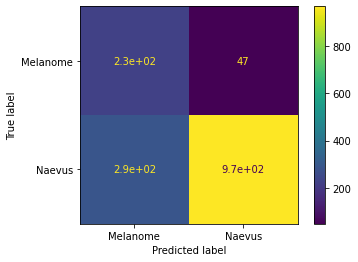

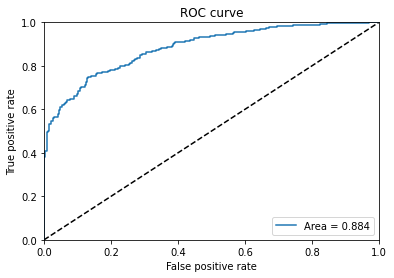

In [ ]:
from xgboost import XGBClassifier
from sklearn.utils import shuffle

featuresNames = ['beta_quad_RGB', 'beta_quad_HSV', 'beta_quad_Lab', 'beta_quad_YCrCb',
                'histos', 'histos_HSV', 'histos_Lab', 'histos_YCrCb',
                 'SPML_4_2', 'SPML_4_2_ycbcr', 'SPML_4_2_cielab', 'SPML_4_2_HSV',
                 'SPO', 'area_quad'
                 ]

loader = DataLoader(featuresNames)
X_train, y_train, X_test, y_test = loader.load(centering=True)

X_train, y_train = shuffle(X_train, y_train)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3)

sample_weight = [4.59 if i == 0 else 1 for i in y_train]

clf = XGBClassifier(n_estimators=1000, learning_rate=0.01)

clf.fit(X_train, y_train, 
             early_stopping_rounds=10,
             eval_set=[(X_valid, y_valid)],
             verbose=False, eval_metric='auc', sample_weight=sample_weight)

predictions = clf.predict_proba(X_test)
visu_results(y_test, predictions, confidence=predictions[:,1])

#print('Cross_val_score (auc):',np.mean(cross_val_score(clf, X_train, y_train, scoring='roc_auc')))

#run_and_test(featuresNames, parameters, LinearSVC(class_weight={0:4.59, 1:1}), hasConfidence=True)

              precision    recall  f1-score   support

    Mélanome       0.44      0.83      0.57       273
      Naevus       0.95      0.77      0.85      1260

    accuracy                           0.78      1533
   macro avg       0.70      0.80      0.71      1533
weighted avg       0.86      0.78      0.80      1533

ROC score on test set :  0.8798418512704227


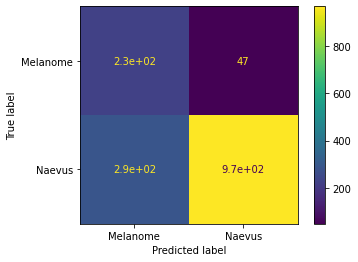

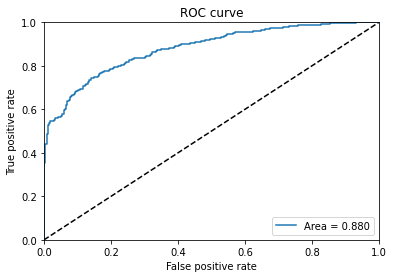

In [ ]:
from xgboost import XGBClassifier
from sklearn.utils import shuffle

featuresNames = ['beta_quad_RGB', 'beta_quad_HSV', 'beta_quad_Lab', 'beta_quad_YCrCb',
                'histos', 'histos_HSV', 'histos_Lab', 'histos_YCrCb',
                 'SPML_4_2', 'SPML_4_2_ycbcr', 'SPML_4_2_cielab', 'SPML_4_2_HSV'
                 ]

loader = DataLoader(featuresNames)
X_train, y_train, X_test, y_test = loader.load(centering=True)

X_train, y_train = shuffle(X_train, y_train)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3)

sample_weight = [4.59 if i == 0 else 1 for i in y_train]

clf = XGBClassifier(n_estimators=1000, learning_rate=0.01)

clf.fit(X_train, y_train, 
             early_stopping_rounds=10,
             eval_set=[(X_valid, y_valid)],
             verbose=False, eval_metric='auc', sample_weight=sample_weight)

predictions = clf.predict_proba(X_test)
visu_results(y_test, predictions, confidence=predictions[:,1])

#print('Cross_val_score (auc):',np.mean(cross_val_score(clf, X_train, y_train, scoring='roc_auc')))

#run_and_test(featuresNames, parameters, LinearSVC(class_weight={0:4.59, 1:1}), hasConfidence=True)

# Vrai features

In [ ]:
featuresNames = ['beta', 'beta_quad', 'M_ColorMean',
                'histos', 'SPML_4_2']

parameters = {
    'C' : (0.01, 0.1, 1),
    'penalty' : ('l1', 'l2')
}
run_and_test(featuresNames, parameters, LinearSVC(class_weight={0:4.59, 1:1}), hasConfidence=True)

Loading features...


KeyboardInterrupt: ignored

In [ ]:
featuresNames = ['beta_quad', 'M_ColorMean',
                'histos', 'SPML_4_2']

In [ ]:
parameters = {
    'C' : (0.01, 0.1, 1),
    'penalty' : ('l1', 'l2')
}
run_and_test(featuresNames, parameters, LinearSVC(class_weight={0:4.59, 1:1}), hasConfidence=True)

In [ ]:
def visu_results(y_test, predictions, normalize=None, confidence=None):
  y_test = np.asarray(y_test)
  if len(y_test.shape) == 1:
    y_testOH = keras.utils.to_categorical(y_test)
  if len(predictions.shape) == 1:
    predictions = keras.utils.to_categorical(predictions)
  print(len(y_test.shape))
  cm = confusion_matrix(np.argmax(y_testOH, axis=1), np.argmax(predictions, axis=1), normalize=normalize)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                    display_labels=('Melanome', 'Naevus'))
  disp.plot()
  print(classification_report(np.argmax(y_testOH, axis=1),
                            np.argmax(predictions, axis=1),
                            target_names=('Mélanome', 'Naevus')))
  if confidence is None:
    print('ROC score on test set : ',roc_auc_score(y_testOH, predictions))
    fpr, tpr, thresh = roc_curve(np.asarray(y_testOH)[:,0], np.asarray(predictions)[:,0])
  else:
    print('ROC score on test set : ',roc_auc_score(y_testOH, confidence))
    fpr, tpr, thresh = roc_curve(np.asarray(y_testOH)[:,0], np.asarray(confidence)[:,0])
  auc_keras = auc(fpr, tpr)
  plt.show()
  plt.figure(1)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr, tpr, label='Area = {:.3f}'.format(auc_keras))
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')
  plt.legend(loc='lower right')
  plt.xlim([0,1])
  plt.ylim([0,1])
  plt.show()

In [ ]:
def get_features(img, mask):
  features = []
  points = np.asarray(get_points(mask))
  center = get_center(points)
  axe1, axe2 = get_axes(points)
  quadrants = make_quadrants(mask, points, axe1, axe2)
  features = f_superpixel_circles_new(img, center, (axe1, axe2), quadrants, n_circles=5, n_lines=3)
  return features

path = '/content/drive/MyDrive/Stage_LIS/Features/'

X, y = load_all_data('TRAIN/', verbose=True, get_features=get_features)
np.savetxt(path+'X_train_SPML_5_3.txt', X)

X, y = load_all_data('TEST/', verbose=True, get_features=get_features)
np.savetxt(path+'X_test_SPML_5_3.txt', X)def get_features(img, mask):
  features = []
  points = np.asarray(get_points(mask))
  center = get_center(points)
  axe1, axe2 = get_axes(points)
  quadrants = make_quadrants(mask, points, axe1, axe2)
  features = f_superpixel_circles_new(img, center, (axe1, axe2), quadrants, n_circles=5, n_lines=3)
  return features

path = '/content/drive/MyDrive/Stage_LIS/Features/'

X, y = load_all_data('TRAIN/', verbose=True, get_features=get_features)
np.savetxt(path+'X_train_SPML_5_3.txt', X)

X, y = load_all_data('TEST/', verbose=True, get_features=get_features)
np.savetxt(path+'X_test_SPML_5_3.txt', X)def get_features(img, mask):
  features = []
  points = np.asarray(get_points(mask))
  center = get_center(points)
  axe1, axe2 = get_axes(points)
  quadrants = make_quadrants(mask, points, axe1, axe2)
  features = f_superpixel_circles_new(img, center, (axe1, axe2), quadrants, n_circles=5, n_lines=3)
  return features

path = '/content/drive/MyDrive/Stage_LIS/Features/'

X, y = load_all_data('TRAIN/', verbose=True, get_features=get_features)
np.savetxt(path+'X_train_SPML_5_3.txt', X)

X, y = load_all_data('TEST/', verbose=True, get_features=get_features)
np.savetxt(path+'X_test_SPML_5_3.txt', X)def get_features(img, mask):
  features = []
  points = np.asarray(get_points(mask))
  center = get_center(points)
  axe1, axe2 = get_axes(points)
  quadrants = make_quadrants(mask, points, axe1, axe2)
  features = f_superpixel_circles_new(img, center, (axe1, axe2), quadrants, n_circles=5, n_lines=3)
  return features

path = '/content/drive/MyDrive/Stage_LIS/Features/'

X, y = load_all_data('TRAIN/', verbose=True, get_features=get_features)
np.savetxt(path+'X_train_SPML_5_3.txt', X)

X, y = load_all_data('TEST/', verbose=True, get_features=get_features)
np.savetxt(path+'X_test_SPML_5_3.txt', X)def get_features(img, mask):
  features = []
  points = np.asarray(get_points(mask))
  center = get_center(points)
  axe1, axe2 = get_axes(points)
  quadrants = make_quadrants(mask, points, axe1, axe2)
  features = f_superpixel_circles_new(img, center, (axe1, axe2), quadrants, n_circles=5, n_lines=3)
  return features

path = '/content/drive/MyDrive/Stage_LIS/Features/'

X, y = load_all_data('TRAIN/', verbose=True, get_features=get_features)
np.savetxt(path+'X_train_SPML_5_3.txt', X)

X, y = load_all_data('TEST/', verbose=True, get_features=get_features)
np.savetxt(path+'X_test_SPML_5_3.txt', X)def get_features(img, mask):
  features = []
  points = np.asarray(get_points(mask))
  center = get_center(points)
  axe1, axe2 = get_axes(points)
  quadrants = make_quadrants(mask, points, axe1, axe2)
  features = f_superpixel_circles_new(img, center, (axe1, axe2), quadrants, n_circles=5, n_lines=3)
  return features

path = '/content/drive/MyDrive/Stage_LIS/Features/'

X, y = load_all_data('TRAIN/', verbose=True, get_features=get_features)
np.savetxt(path+'X_train_SPML_5_3.txt', X)

X, y = load_all_data('TEST/', verbose=True, get_features=get_features)
np.savetxt(path+'X_test_SPML_5_3.txt', X)def get_features(img, mask):
  features = []
  points = np.asarray(get_points(mask))
  center = get_center(points)
  axe1, axe2 = get_axes(points)
  quadrants = make_quadrants(mask, points, axe1, axe2)
  features = f_superpixel_circles_new(img, center, (axe1, axe2), quadrants, n_circles=5, n_lines=3)
  return features

path = '/content/drive/MyDrive/Stage_LIS/Features/'

X, y = load_all_data('TRAIN/', verbose=True, get_features=get_features)
np.savetxt(path+'X_train_SPML_5_3.txt', X)

X, y = load_all_data('TEST/', verbose=True, get_features=get_features)
np.savetxt(path+'X_test_SPML_5_3.txt', X)def get_features(img, mask):
  features = []
  points = np.asarray(get_points(mask))
  center = get_center(points)
  axe1, axe2 = get_axes(points)
  quadrants = make_quadrants(mask, points, axe1, axe2)
  features = f_superpixel_circles_new(img, center, (axe1, axe2), quadrants, n_circles=5, n_lines=3)
  return features

path = '/content/drive/MyDrive/Stage_LIS/Features/'

X, y = load_all_data('TRAIN/', verbose=True, get_features=get_features)
np.savetxt(path+'X_train_SPML_5_3.txt', X)

X, y = load_all_data('TEST/', verbose=True, get_features=get_features)
np.savetxt(path+'X_test_SPML_5_3.txt', X)lolqQqsssddsfdsfssdf88ssdef get_features(img, mask):
  features = []
  points = np.asarray(get_points(mask))
  center = get_center(points)
  axe1, axe2 = get_axes(points)
  quadrants = make_quadrants(mask, points, axe1, axe2)
  features = f_superpixel_circles_new(img, center, (axe1, axe2), quadrants, n_circles=5, n_lines=3)
  return features

path = '/content/drive/MyDrive/Stage_LIS/Features/'

X, y = load_all_data('TRAIN/', verbose=True, get_features=get_features)
np.savetxt(path+'X_train_SPML_5_3.txt', X)

X, y = load_all_data('TEST/', verbose=True, get_features=get_features)
np.savetxt(path+'X_test_SPML_5_3.txt', X)dddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddpasfrom sklearn.ensemble import AdaBoostClassifier

parameters = {
    'degree' : (3,4,5)
}

clf = SVC(class_weight={0:4.59,1:1}, probability=True, C=0.1)

print('Loading features...')
loader = DataLoader(featuresNames)
X_train, y_train, X_test, y_test = loader.load()
print('GridSeach...')
gs = GridSearchCV(clf, parameters, scoring='roc_auc', n_jobs=-1, verbose=10).fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_estimator_)
clf = gs.best_estimator_

print('Best estimator...')
clf.fit(X_train, y_train)

predictions = clf.predict(X_test)
confidence = clf.predict_proba(X_test)

visu_results(y_test, predictions, confidence=confidence)

print('Cross_val_score (auc):',np.mean(cross_val_score(clf, X_train, y_train, scoring='roc_auc')))

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

parameters = {
    'C' : (0.01, 0.1, 1),
}

clf = SVC(class_weight={0:4.59,1:1}, probability=True, kernel='poly')

print('Loading features...')
loader = DataLoader(featuresNames)
X_train, y_train, X_test, y_test = loader.load()
print('GridSeach...')
gs = GridSearchCV(clf, parameters, scoring='roc_auc', n_jobs=-1, verbose=10).fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_estimator_)
clf = gs.best_estimator_

print('Best estimator...')
clf.fit(X_train, y_train)

predictions = clf.predict(X_test)
confidence = clf.predict_proba(X_test)

visu_results(y_test, predictions, confidence=confidence)

print('Cross_val_score (auc):',np.mean(cross_val_score(clf, X_train, y_train, scoring='roc_auc')))

# CSV

              precision    recall  f1-score   support

    Mélanome       0.41      0.84      0.55       273
      Naevus       0.96      0.74      0.83      1260

    accuracy                           0.76      1533
   macro avg       0.68      0.79      0.69      1533
weighted avg       0.86      0.76      0.78      1533

ROC score on test set :  0.8827780684923543


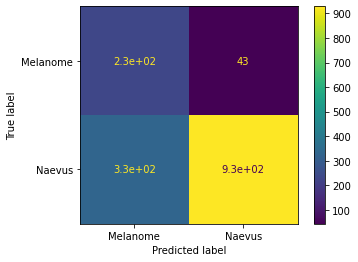

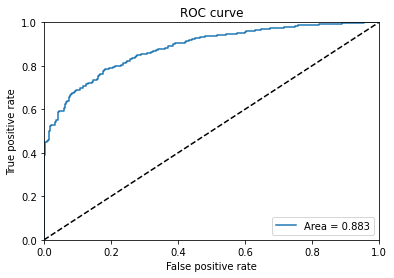

In [ ]:
featuresNames = ['beta_quad_RGB', 'beta_quad_HSV', 'beta_quad_Lab', 'beta_quad_YCrCb',
                'histos', 'histos_HSV', 'histos_Lab', 'histos_YCrCb',
                'SPML_4_2', 'SPML_4_2_HSV', 'SPML_4_2_cielab', 'SPML_4_2_ycbcr'
                ,'SPO', 'SP60_4']

loader = DataLoader(featuresNames)
X_train, y_train, X_test, y_test = loader.load(centering=True)

X_train, y_train = shuffle(X_train, y_train)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3)

sample_weight = [4.59 if i == 0 else 1 for i in y_train]

clf = XGBClassifier(n_estimators=1000, learning_rate=0.01)

clf.fit(X_train, y_train, 
             early_stopping_rounds=10,
             eval_set=[(X_valid, y_valid)],
             verbose=False, eval_metric='auc', sample_weight=sample_weight)

predictions = clf.predict_proba(X_test)
visu_results(y_test, predictions, confidence=predictions[:,1])

In [ ]:
  featuresNames = ['beta_quad_RGB', 'beta_quad_HSV', 'beta_quad_Lab', 'beta_quad_YCrCb',
                  'histos', 'histos_HSV', 'histos_Lab', 'histos_YCrCb',
                  'SPML_4_2', 'SPML_4_2_HSV', 'SPML_4_2_cielab', 'SPML_4_2_ycbcr'
                  ,'SPO', 'SP60_4']

loader = DataLoader(featuresNames)
X_train, y_train, X_test, y_test = loader.load(centering=True)

NameError: ignored

In [ ]:
np.savetxt('features.csv', X_train, delimiter=',')

NameError: ignored

In [ ]:
index2name = []
for i in range(36):
  index2name.append('beta_quad_RGB '+str(i))
for i in range(36):
  index2name.append('beta_quad_HSV '+str(i))
for i in range(36):
  index2name.append('beta_quad_Lab '+str(i))
for i in range(36):
  index2name.append('beta_quad_YCrCb '+str(i))
for i in range(90):
  index2name.append('histos_RGB '+str(i))
for i in range(90):
  index2name.append('histos_HSV '+str(i))
for i in range(90):
  index2name.append('histos_Lab '+str(i))
for i in range(90):
  index2name.append('histos_YCrCb '+str(i))
for i in range(12):
  index2name.append('SPML_4_2_RGB '+str(i))
for i in range(12):
  index2name.append('SPML_4_2_HSV '+str(i))
for i in range(12):
  index2name.append('SPML_4_2_Lab '+str(i))
for i in range(12):
  index2name.append('SPML_4_2_YCrCb '+str(i))
for i in range(150):
  index2name.append('SPO '+str(i))
for i in range(12):
  index2name.append('SP60_4 '+str(i))

In [ ]:
print(X_train.shape)
print(np.asarray(index2name).shape)

(6124, 714)
(714,)


In [ ]:
import pandas as pd

csv_file = pd.DataFrame(data=X_train, columns=index2name)

In [ ]:
csv_file

,beta_quad_RGB 0,beta_quad_RGB 1,beta_quad_RGB 2,beta_quad_RGB 3,beta_quad_RGB 4,beta_quad_RGB 5,beta_quad_RGB 6,beta_quad_RGB 7,beta_quad_RGB 8,beta_quad_RGB 9,beta_quad_RGB 10,beta_quad_RGB 11,beta_quad_RGB 12,beta_quad_RGB 13,beta_quad_RGB 14,beta_quad_RGB 15,beta_quad_RGB 16,beta_quad_RGB 17,beta_quad_RGB 18,beta_quad_RGB 19,beta_quad_RGB 20,beta_quad_RGB 21,beta_quad_RGB 22,beta_quad_RGB 23,beta_quad_RGB 24,beta_quad_RGB 25,beta_quad_RGB 26,beta_quad_RGB 27,beta_quad_RGB 28,beta_quad_RGB 29,beta_quad_RGB 30,beta_quad_RGB 31,beta_quad_RGB 32,beta_quad_RGB 33,beta_quad_RGB 34,beta_quad_RGB 35,beta_quad_HSV 0,beta_quad_HSV 1,beta_quad_HSV 2,beta_quad_HSV 3,...,SPO 122,SPO 123,SPO 124,SPO 125,SPO 126,SPO 127,SPO 128,SPO 129,SPO 130,SPO 131,SPO 132,SPO 133,SPO 134,SPO 135,SPO 136,SPO 137,SPO 138,SPO 139,SPO 140,SPO 141,SPO 142,SPO 143,SPO 144,SPO 145,SPO 146,SPO 147,SPO 148,SPO 149,SP60_4 0,SP60_4 1,SP60_4 2,SP60_4 3,SP60_4 4,SP60_4 5,SP60_4 6,SP60_4 7,SP60_4 8,SP60_4 9,SP60_4 10,SP60_4 11
0,-0.407186,-0.399348,-0.338131,-0.297034,-0.379934,-0.348445,-0.415827,-0.452531,-0.492181,-0.431611,-0.439251,-0.471611,-0.402982,-0.377922,-0.311424,-0.243259,-0.288449,-0.283006,-0.390936,-0.431182,-0.492863,-0.430140,-0.433866,-0.470924,-0.412438,-0.393890,-0.333039,-0.229516,-0.324240,-0.329711,-0.383904,-0.433395,-0.492698,-0.450151,-0.444865,-0.464507,-0.474217,-0.113162,-0.340409,-0.436694,...,-0.498481,-0.480399,-0.499227,-0.485734,-0.472168,-0.489359,-0.477636,-0.466979,-0.497544,-0.493852,-0.450333,-0.494004,-0.476512,-0.467348,-0.487644,-0.483596,-0.473953,-0.491262,-0.496025,-0.437366,-0.476059,-0.478447,-0.437382,-0.476057,-0.478453,-0.437382,-0.476057,-0.478453,-0.459620,-0.459716,-0.418415,-0.461832,-0.445274,-0.364245,-0.434454,-0.399830,-0.359574,-0.418803,-0.444365,-0.436054
1,-0.255668,-0.363542,-0.415636,-0.338086,-0.400946,-0.441981,-0.470896,-0.482256,-0.482904,-0.183005,-0.281647,-0.217321,-0.260399,-0.347038,-0.433464,-0.356027,-0.389985,-0.432916,-0.470835,-0.476114,-0.487030,-0.223848,-0.312027,-0.309120,-0.330398,-0.377758,-0.438582,-0.399346,-0.428783,-0.454667,-0.474569,-0.479100,-0.489214,-0.329644,-0.394400,-0.339849,0.144582,-0.214475,-0.414267,-0.354855,...,-0.427105,-0.399924,-0.441691,-0.497482,-0.409735,-0.438673,-0.488305,-0.389131,-0.431682,-0.490325,-0.404172,-0.454759,-0.496198,-0.396354,-0.455153,-0.488633,-0.410265,-0.468715,-0.495325,-0.403664,-0.463814,-0.499499,-0.403680,-0.463812,-0.499505,-0.403680,-0.463812,-0.499505,-0.347981,-0.379147,-0.439394,-0.268448,-0.325871,-0.427342,-0.358824,-0.408319,-0.461702,-0.408832,-0.432953,-0.479592
2,-0.407609,-0.418788,-0.400705,-0.232525,-0.332320,-0.393486,-0.374038,-0.439737,-0.493914,-0.449300,-0.464835,-0.458334,-0.425893,-0.419840,-0.402463,-0.274902,-0.342664,-0.370235,-0.385002,-0.441655,-0.494593,-0.423373,-0.449467,-0.475134,-0.426555,-0.420116,-0.351724,-0.246209,-0.336760,-0.371856,-0.388554,-0.448465,-0.495420,-0.436814,-0.456095,-0.484023,-0.473698,-0.396944,-0.401212,-0.439205,...,-0.492117,-0.453497,-0.461969,-0.494742,-0.475536,-0.467525,-0.498332,-0.491073,-0.482674,-0.494907,-0.497969,-0.481295,-0.494862,-0.495617,-0.498658,-0.480854,-0.480630,-0.488581,-0.496464,-0.483593,-0.499084,-0.497639,-0.474004,-0.473703,-0.487439,-0.474004,-0.473703,-0.487439,-0.293349,-0.310427,-0.278555,-0.446565,-0.447761,-0.431166,-0.466387,-0.440577,-0.421986,-0.361823,-0.330243,-0.325850
3,-0.299415,-0.332525,-0.369577,-0.389955,-0.362187,-0.309735,-0.494948,-0.492867,-0.479058,-0.400964,-0.423174,-0.418111,-0.006454,-0.044217,-0.182972,-0.342858,-0.262067,-0.209974,-0.488665,-0.453371,-0.458091,-0.292623,-0.280256,-0.318879,-0.261909,-0.255127,-0.243280,-0.317351,-0.283241,-0.256877,-0.492770,-0.481204,-0.479117,-0.341424,-0.353221,-0.398637,-0.426463,-0.242917,-0.367231,-0.327341,...,-0.474057,-0.446213,-0.448046,-0.471095,-0.463320,-0.477552,-0.471855,-0.483782,-0.499330,-0.489487,-0.486922,-0.488790,-0.496089,-0.427086,-0.453665,-0.485373,-0.427095,-0

In [ ]:
csv_file.to_csv('feature_true.csv')

In [ ]:
import pandas as pd
test = pd.read_csv('/content/feature_true.csv', index_col=0)
test

,beta_quad_RGB 0,beta_quad_RGB 1,beta_quad_RGB 2,beta_quad_RGB 3,beta_quad_RGB 4,beta_quad_RGB 5,beta_quad_RGB 6,beta_quad_RGB 7,beta_quad_RGB 8,beta_quad_RGB 9,beta_quad_RGB 10,beta_quad_RGB 11,beta_quad_RGB 12,beta_quad_RGB 13,beta_quad_RGB 14,beta_quad_RGB 15,beta_quad_RGB 16,beta_quad_RGB 17,beta_quad_RGB 18,beta_quad_RGB 19,beta_quad_RGB 20,beta_quad_RGB 21,beta_quad_RGB 22,beta_quad_RGB 23,beta_quad_RGB 24,beta_quad_RGB 25,beta_quad_RGB 26,beta_quad_RGB 27,beta_quad_RGB 28,beta_quad_RGB 29,beta_quad_RGB 30,beta_quad_RGB 31,beta_quad_RGB 32,beta_quad_RGB 33,beta_quad_RGB 34,beta_quad_RGB 35,beta_quad_HSV 0,beta_quad_HSV 1,beta_quad_HSV 2,beta_quad_HSV 3,...,SPO 122,SPO 123,SPO 124,SPO 125,SPO 126,SPO 127,SPO 128,SPO 129,SPO 130,SPO 131,SPO 132,SPO 133,SPO 134,SPO 135,SPO 136,SPO 137,SPO 138,SPO 139,SPO 140,SPO 141,SPO 142,SPO 143,SPO 144,SPO 145,SPO 146,SPO 147,SPO 148,SPO 149,SP60_4 0,SP60_4 1,SP60_4 2,SP60_4 3,SP60_4 4,SP60_4 5,SP60_4 6,SP60_4 7,SP60_4 8,SP60_4 9,SP60_4 10,SP60_4 11
0,-0.407186,-0.399348,-0.338131,-0.297034,-0.379934,-0.348445,-0.415827,-0.452531,-0.492181,-0.431611,-0.439251,-0.471611,-0.402982,-0.377922,-0.311424,-0.243259,-0.288449,-0.283006,-0.390936,-0.431182,-0.492863,-0.430140,-0.433866,-0.470924,-0.412438,-0.393890,-0.333039,-0.229516,-0.324240,-0.329711,-0.383904,-0.433395,-0.492698,-0.450151,-0.444865,-0.464507,-0.474217,-0.113162,-0.340409,-0.436694,...,-0.498481,-0.480399,-0.499227,-0.485734,-0.472168,-0.489359,-0.477636,-0.466979,-0.497544,-0.493852,-0.450333,-0.494004,-0.476512,-0.467348,-0.487644,-0.483596,-0.473953,-0.491262,-0.496025,-0.437366,-0.476059,-0.478447,-0.437382,-0.476057,-0.478453,-0.437382,-0.476057,-0.478453,-0.459620,-0.459716,-0.418415,-0.461832,-0.445274,-0.364245,-0.434454,-0.399830,-0.359574,-0.418803,-0.444365,-0.436054
1,-0.255668,-0.363542,-0.415636,-0.338086,-0.400946,-0.441981,-0.470896,-0.482256,-0.482904,-0.183005,-0.281647,-0.217321,-0.260399,-0.347038,-0.433464,-0.356027,-0.389985,-0.432916,-0.470835,-0.476114,-0.487030,-0.223848,-0.312027,-0.309120,-0.330398,-0.377758,-0.438582,-0.399346,-0.428783,-0.454667,-0.474569,-0.479100,-0.489214,-0.329644,-0.394400,-0.339849,0.144582,-0.214475,-0.414267,-0.354855,...,-0.427105,-0.399924,-0.441691,-0.497482,-0.409735,-0.438673,-0.488305,-0.389131,-0.431682,-0.490325,-0.404172,-0.454759,-0.496198,-0.396354,-0.455153,-0.488633,-0.410265,-0.468715,-0.495325,-0.403664,-0.463814,-0.499499,-0.403680,-0.463812,-0.499505,-0.403680,-0.463812,-0.499505,-0.347981,-0.379147,-0.439394,-0.268448,-0.325871,-0.427342,-0.358824,-0.408319,-0.461702,-0.408832,-0.432953,-0.479592
2,-0.407609,-0.418788,-0.400705,-0.232525,-0.332320,-0.393486,-0.374038,-0.439737,-0.493914,-0.449300,-0.464835,-0.458334,-0.425893,-0.419840,-0.402463,-0.274902,-0.342664,-0.370235,-0.385002,-0.441655,-0.494593,-0.423373,-0.449467,-0.475134,-0.426555,-0.420116,-0.351724,-0.246209,-0.336760,-0.371856,-0.388554,-0.448465,-0.495420,-0.436814,-0.456095,-0.484023,-0.473698,-0.396944,-0.401212,-0.439205,...,-0.492117,-0.453497,-0.461969,-0.494742,-0.475536,-0.467525,-0.498332,-0.491073,-0.482674,-0.494907,-0.497969,-0.481295,-0.494862,-0.495617,-0.498658,-0.480854,-0.480630,-0.488581,-0.496464,-0.483593,-0.499084,-0.497639,-0.474004,-0.473703,-0.487439,-0.474004,-0.473703,-0.487439,-0.293349,-0.310427,-0.278555,-0.446565,-0.447761,-0.431166,-0.466387,-0.440577,-0.421986,-0.361823,-0.330243,-0.325850
3,-0.299415,-0.332525,-0.369577,-0.389955,-0.362187,-0.309735,-0.494948,-0.492867,-0.479058,-0.400964,-0.423174,-0.418111,-0.006454,-0.044217,-0.182972,-0.342858,-0.262067,-0.209974,-0.488665,-0.453371,-0.458091,-0.292623,-0.280256,-0.318879,-0.261909,-0.255127,-0.243280,-0.317351,-0.283241,-0.256877,-0.492770,-0.481204,-0.479117,-0.341424,-0.353221,-0.398637,-0.426463,-0.242917,-0.367231,-0.327341,...,-0.474057,-0.446213,-0.448046,-0.471095,-0.463320,-0.477552,-0.471855,-0.483782,-0.499330,-0.489487,-0.486922,-0.488790,-0.496089,-0.427086,-0.453665,-0.485373,-0.427095,-0

Loading features...
GridSeach...
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   54.2s finished


0.8599471549934845
LinearSVC(C=0.01, class_weight={0: 4.59, 1: 1}, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)
Best estimator...
              precision    recall  f1-score   support

    Mélanome       0.45      0.82      0.58       273
      Naevus       0.95      0.78      0.86      1260

    accuracy                           0.79      1533
   macro avg       0.70      0.80      0.72      1533
weighted avg       0.86      0.79      0.81      1533

ROC score on test set :  0.8794581080295366


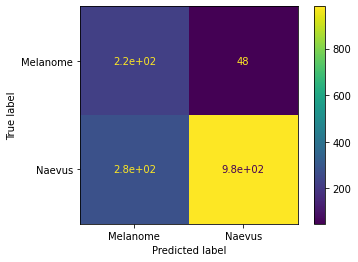

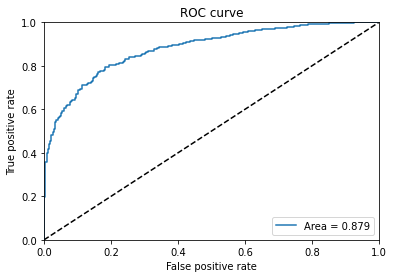

Cross_val_score (auc): 0.8599471549934845


In [ ]:
parameters = {
    'C' : (0.01, 0.1, 1),
    'penalty' : ('l1', 'l2')
}
run_and_test(featuresNames, parameters, LinearSVC(class_weight={0:4.59, 1:1}), hasConfidence=True)